## Libraries

In [1]:
import os, sys, glob
from osgeo import gdal, osr, ogr
import itertools
from datetime import datetime,timedelta
import numpy as np
import string
from joblib import Parallel, delayed
import rasterio as rio
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import xarray as xr
import rioxarray as rxr

from sklearn import metrics
import ast
import statsmodels.api as sm
from adjustText import adjust_text
import string


In [ ]:
import Global_Functions
import Gdal_Functions

import ee
ee.Authenticate(force=False)


True

## 3) Gridding to 0.005 x 0.0025 for yearly fire visualization

### 3.1) JD

In [8]:
zone, dataset = 'Siberia', 'Lndst'
local_path = f'/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA'
gridpath = '/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/PeatFire/Summaries'
## GDAL_CACHEMAX IS 5% * 128GB ~ 6.4 GB, set it to 30 GB for speed up
gdal.SetCacheMax(30*1024**3)
wgs = osr.SpatialReference()
wgs.ImportFromEPSG(4326)

xres, yres = (0.01, -0.005)
kwargs = dict(srcNodata=0, dstNodata=None, 
              bounds=[63, 58, 180, 74], 
             xRes=xres, yRes=yres, resampleAlg='max',
             crs=wgs, n_threads=15)
for year in np.arange(2023, 2000, -1)[:]:
    name = f'BA_{zone}_{dataset}_{year}_JD_{str(xres).replace(".", "")}{str(yres).replace(".", "")}D'
    files = glob.glob(f'{local_path}/{zone}/ByTile/**/Enhanced/Yearly/*_{zone}_{dataset}_{year}_*_JD_Correct_Patches.tif')
    # ls = Parallel(n_jobs=10, verbose=100) (delayed(apply_mask_BA) (f) for f in files)       
    Global_Functions.mosaic_gdal(name, outPath=gridpath, files=files, **kwargs)


289 /media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/ByTile/TILE-60N063E/Enhanced/Yearly/BAMT_BA_Siberia_Lndst_2023_TILE-60N063E_JD_Correct_Patches.tif
No dstNodata was given, the the 1st list file is used
289 /media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/ByTile/TILE-60N063E/Enhanced/Yearly/BAMT_BA_Siberia_Lndst_2022_TILE-60N063E_JD_Correct_Patches.tif
No dstNodata was given, the the 1st list file is used
289 /media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/ByTile/TILE-60N063E/Enhanced/Yearly/BAMT_BA_Siberia_Lndst_2021_TILE-60N063E_JD_Correct_Patches.tif
No dstNodata was given, the the 1st list file is used
289 /media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/ByTile/TILE-60N063E/Enhanced/Yearly/BAMT_BA_Siberia_Lndst_2020_TILE-60N063E_JD_Correct_Patches.tif
No dstNodata was given, the the 1st list file is used
289 /media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/ByTile/TILE-60N063E/Enhanced/Yearly/BAMT_BA_Siberia_Lndst_2019_TILE-

### 3.2) PEATMAP

In [117]:
from osgeo_utils.gdal_calc import Calc
def apply_mask_peat(f):
    tile = f.split('/')[-1][:-4]
    tmp = f'/vsimem/peat_{tile}.tif'
    Calc(calc="logical_and(A>1, A<4)*1", A=f, outfile=tmp, overwrite=True)    
    return tmp

In [ ]:
def mosaic_gdal(naming, outPath, pattern=None, inputPath=None, vrtPath='/vsimem', files=None, refPath=None, 
                profile=None, srcNodata=None, dstNodata='Auto', resampleAlg='near', crs=None, xRes=None, yRes=None,
                n_threads=4, bounds=None, cutline=None):
    if files:
        ls = files
    else:
        ls = []
        for f in sorted(glob.glob(f'{inputPath}/**/*.tif', recursive=True)):
            if pattern.search(f):
                ls.append(f)
    print(len(ls), ls[0])
    vrt = gdal.BuildVRT(f'{vrtPath}/{naming}.vrt', ls, srcNodata=srcNodata)
    vrt.FlushCache()
    if refPath:
        with rio.open(refPath) as ref:
            profile = ref.profile
    if profile:       
        left = profile['transform'][2]
        bottom = profile['transform'][5] + profile['transform'][4] * profile['height']
        right = profile['transform'][2] + profile['transform'][0] * profile['width']
        top = profile['transform'][5]
        bounds = [left, bottom, right, top]
        xRes = profile['transform'][0]
        yRes = profile['transform'][4]
        crs = profile['crs'].to_wkt() 
    
    if not yRes:
        src = rio.open(ls[0])
        profile = src.profile
        xRes = profile['transform'][0]
        yRes = profile['transform'][4]          
        print("No Resolution was given, the the 1st list file is used")
    if dstNodata == 'Auto':
        src = rio.open(ls[0])
        profile = src.profile
        dstNodata = profile['nodata']     
        print("No dstNodata was given, the the 1st list file is used")
    if not crs:
        src = rio.open(ls[0])
        profile = src.profile
        crs = profile['crs'].to_wkt()         
        print("No CRS was given, the the 1st list file is used")
    elif not isinstance(crs, str):
        crs = crs.ExportToWkt()    
    if cutline:
        crop = True
    else:
        crop = False
    gdal.SetConfigOption('GDAL_NUM_THREADS', str(n_threads))  
    os.makedirs(outPath, exist_ok=True)      
    gdal.Warp(f'{outPath}/{naming}.tif', f'{vrtPath}/{naming}.vrt', dstSRS=crs,
          resampleAlg=resampleAlg, outputBounds=bounds, xRes=xRes, yRes=yRes, 
          srcNodata=srcNodata, dstNodata=dstNodata, 
          cutlineDSName=cutline, cropToCutline=crop,
          multithread=True, creationOptions=['COMPRESS=LZW', 'TILED=YES'])

In [ ]:
zone, dataset = 'Siberia', 'Lndst'
local_path = f'/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA'
gridpath = '/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/PeatFire/Summaries'
## GDAL_CACHEMAX IS 5% * 128GB ~ 6.4 GB, set it to 30 GB for speed up
gdal.SetCacheMax(30*1024**3)
wgs = osr.SpatialReference()
wgs.ImportFromEPSG(4326)

xres, yres = (0.01, -0.005)
xres, yres = (0.005, -0.0025)
args = dict(srcNodata=None, dstNodata=None, 
              bounds=[63, 58, 180, 74], 
             xRes=xres, yRes=yres, resampleAlg='mode',
             crs=wgs, n_threads=15)
name = f'PeatMap_{zone}_{str(xres).replace(".", "")}{str(yres).replace(".", "")}D'
files = glob.glob(f'{local_path}/{zone}/PeatMap/Raw/*.tif')
ls = []
for f in files:
    ls.append(apply_mask_peat(f))
ls = Parallel(n_jobs=10, verbose=100) (delayed(apply_mask_peat) (f) for f in files)      
mosaic_gdal(name, outPath=gridpath, files=ls, **args)

100 /vsimem/peat_n55e060.tif


## 6) PeatFire drivers
### 6.1) Aggregate variables

In [3]:
local_path = '/media/amin/DISK6T/PhD/Landsat_BA/Siberia'


In [4]:
climate_layers = dict(
             TerraClimate_Means={'bands': ['Tmax', 'Tmin', 'VPD', 
                                       'Radiation',  'PDSI', 'CWD','Moisture'], 'res': 1/24,
                                 'scales': [0.1, 0.1, 0.01, 0.1, 0.01, 0.1, 0.1]},
             TerraClimate_Anomalies={'bands': ['Tmax_Anomaly', 'Tmin_Anomaly', 'VPD_Anomaly', 
                                       'Radiation_Anomaly',  'PDSI_Anomaly', 'CWD_Anomaly','Moisture_Anomaly'], 'res': 1/24},
             ECMWF_CEMS_Means={'bands': ['DMC', 'FFMC'], 'res': 0.25},
             ECMWF_CEMS_DCMeans={'bands': ['DC'], 'res': 0.25},
             ECMWF_CEMS_Anomalies={'bands': ['DMC_Anomaly', 'FFMC_Anomaly', 'FWI_Anomaly'], 'res': 0.25},
             Gridded_LST_Anomaly={'bands': ['LST_Anomaly'], 'res': 1},
             Gridded_LST_Persistence={'bands': ['LST_Persistence'], 'res': 1},
             Gridded_LST_Mean={'bands': ['LST'], 'res': 1, 'scales': [0.02]},
                     )

In [399]:
for f in glob.glob('/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/PeatFire/BG_CC/data/LST_Mean/*tif'):
    print(f)
    with rio.open(f) as src:
        profile = src.profile
    profile['transform'] = rio.Affine(*[1, 0, 63, 0, -1, 74])
    profile['width'] = 180 - 63
    profile['height'] = 74 - 58
    out_path = '/media/amin/DISK6T/PhD/Landsat_BA/Siberia/PeatFire/BG_CC/data/Gridded_LST_Mean'
    os.makedirs(out_path, exist_ok=True)
    Global_Functions.resample_by_ref(f, f"{out_path}/Gridded_LST_Mean_Siberia_1D_{f.split('_')[-1]}",
                                    profile=profile, method='average', nodata=float('nan'))

/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/PeatFire/BG_CC/data/LST_Mean/LST_Mean_Siberia_2001.tif
/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/PeatFire/BG_CC/data/LST_Mean/LST_Mean_Siberia_2002.tif
/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/PeatFire/BG_CC/data/LST_Mean/LST_Mean_Siberia_2003.tif
/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/PeatFire/BG_CC/data/LST_Mean/LST_Mean_Siberia_2004.tif
/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/PeatFire/BG_CC/data/LST_Mean/LST_Mean_Siberia_2005.tif
/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/PeatFire/BG_CC/data/LST_Mean/LST_Mean_Siberia_2006.tif
/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/PeatFire/BG_CC/data/LST_Mean/LST_Mean_Siberia_2007.tif
/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/PeatFire/BG_CC/data/LST_Mean/LST_Mean_Siberia_2008.tif
/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/PeatFire/BG_CC/data/

In [ ]:
grid_res = 1
ls = []
for year in range(2001, 2024):
    print(year)
    climate = {}
    for l in climate_layers.keys():
        print(l)
        ds = gdal.Open(glob.glob(f'{local_path}/PeatFire/BG_CC/data/{l}/{l}_Siberia*_{year}.tif')[0])
        gt = ds.GetGeoTransform()
        xmin, ymin, xmax, ymax = 63, 58, 180, 74
        index_lat = slice(int((ymax - gt[3])/gt[5]), int((ymin - gt[3])/gt[5]))
        index_lon = slice(int((xmin - gt[0])/gt[1]), int((xmax - gt[0])/gt[1]))
        for i, band in enumerate(climate_layers[l]['bands']):
            arr = ds.GetRasterBand(i+1).ReadAsArray()[index_lat, index_lon]
            scale = int(grid_res / climate_layers[l]['res'])
            climate[band] = {}
            climate[band]["dims"] = (("time", "lat", "lon"))
            climate[band]["data"] = np.expand_dims(np.nanmean(arr.reshape(arr.shape[0] // scale, scale, 
                                        arr.shape[1] // scale, scale), axis=(1, 3)), axis=0)
            if 'scales' in climate_layers[l].keys():
                print(band, climate_layers[l]['scales'][i])
                climate[band]["data"] = climate[band]["data"] * climate_layers[l]['scales'][i]

            print(band, arr.shape, scale, climate[band]["data"].shape)
            
    coords = {"time": {"dims": ("time",), "data": [datetime.strptime(str(year), "%Y")]},
              "lat": {"dims": ("lat",), "data": np.arange(ymax-0.5*grid_res, ymin-0.5*grid_res, -grid_res)},
              "lon": {"dims": ("lon",), "data": np.arange(xmin+0.5*grid_res, xmax+0.5*grid_res, grid_res)},}
    data_dict = {"coords": coords, "dims": {"time":1, "lat":16, "lon":117}, "data_vars": climate}
    da = xr.Dataset.from_dict(data_dict)   
    ls.append(da)    
        

2001
TerraClimate_Means
Tmax 0.1
Tmax (384, 2808) 24 (1, 16, 117)
Tmin 0.1
Tmin (384, 2808) 24 (1, 16, 117)
VPD 0.01
VPD (384, 2808) 24 (1, 16, 117)
Radiation 0.1
Radiation (384, 2808) 24 (1, 16, 117)
PDSI 0.01
PDSI (384, 2808) 24 (1, 16, 117)
CWD 0.1
CWD (384, 2808) 24 (1, 16, 117)
Moisture 0.1
Moisture (384, 2808) 24 (1, 16, 117)
ECMWF_CEMS_Means
DMC (64, 468) 4 (1, 16, 117)
FFMC (64, 468) 4 (1, 16, 117)
ECMWF_CEMS_DCMeans
DC (64, 468) 4 (1, 16, 117)
Gridded_LST_Mean
LST 0.02
LST (16, 117) 1 (1, 16, 117)
2002
TerraClimate_Means


Mean of empty slice


Tmax 0.1
Tmax (384, 2808) 24 (1, 16, 117)
Tmin 0.1
Tmin (384, 2808) 24 (1, 16, 117)
VPD 0.01
VPD (384, 2808) 24 (1, 16, 117)
Radiation 0.1
Radiation (384, 2808) 24 (1, 16, 117)
PDSI 0.01
PDSI (384, 2808) 24 (1, 16, 117)
CWD 0.1
CWD (384, 2808) 24 (1, 16, 117)
Moisture 0.1
Moisture (384, 2808) 24 (1, 16, 117)
ECMWF_CEMS_Means
DMC (64, 468) 4 (1, 16, 117)
FFMC (64, 468) 4 (1, 16, 117)
ECMWF_CEMS_DCMeans
DC (64, 468) 4 (1, 16, 117)
Gridded_LST_Mean
LST 0.02
LST (16, 117) 1 (1, 16, 117)
2003
TerraClimate_Means
Tmax 0.1
Tmax (384, 2808) 24 (1, 16, 117)
Tmin 0.1
Tmin (384, 2808) 24 (1, 16, 117)
VPD 0.01
VPD (384, 2808) 24 (1, 16, 117)
Radiation 0.1
Radiation (384, 2808) 24 (1, 16, 117)
PDSI 0.01
PDSI (384, 2808) 24 (1, 16, 117)
CWD 0.1
CWD (384, 2808) 24 (1, 16, 117)
Moisture 0.1
Moisture (384, 2808) 24 (1, 16, 117)
ECMWF_CEMS_Means
DMC (64, 468) 4 (1, 16, 117)
FFMC (64, 468) 4 (1, 16, 117)
ECMWF_CEMS_DCMeans
DC (64, 468) 4 (1, 16, 117)
Gridded_LST_Mean
LST 0.02
LST (16, 117) 1 (1, 16, 117)


In [59]:
dataset = xr.merge(ls)
dataset

<xarray.Dataset>
Dimensions:    (time: 23, lat: 16, lon: 117)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2002-01-01 ... 2023-01-01
  * lat        (lat) float64 73.5 72.5 71.5 70.5 69.5 ... 61.5 60.5 59.5 58.5
  * lon        (lon) float64 63.5 64.5 65.5 66.5 ... 176.5 177.5 178.5 179.5
Data variables:
    Tmax       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    Tmin       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    VPD        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    Radiation  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    PDSI       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    CWD        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    Moisture   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    DMC        (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    FFMC       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    DC         (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    LST        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

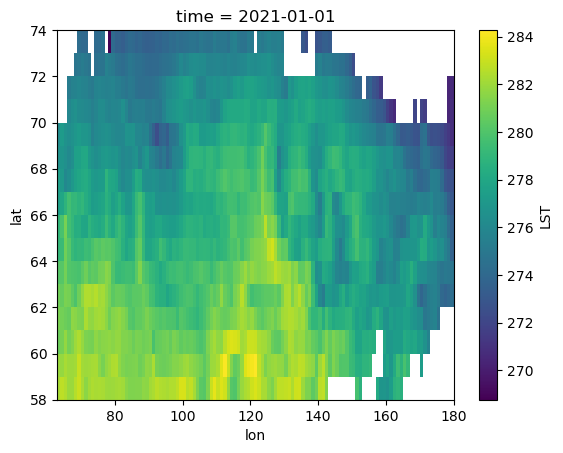

In [42]:
dataset.LST.isel(time=20).plot(cmap='viridis')

In [43]:
dataset['LST'] = dataset['LST'] - 273.15
dataset.to_netcdf(f"{local_path}/PeatFire/BG_CC/data/Siberia_TerraClimate_1D.nc")

In [46]:
dataset

<xarray.Dataset>
Dimensions:            (time: 23, lat: 16, lon: 117)
Coordinates:
  * time               (time) datetime64[ns] 2001-01-01 ... 2023-01-01
  * lat                (lat) float64 73.5 72.5 71.5 70.5 ... 61.5 60.5 59.5 58.5
  * lon                (lon) float64 63.5 64.5 65.5 66.5 ... 177.5 178.5 179.5
Data variables: (12/23)
    Tmax               (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    Tmin               (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    VPD                (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    Radiation          (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    PDSI               (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    CWD                (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ...                 ...
    DMC_Anomaly        (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    FFMC_Anomaly       (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    DC_Anomaly         (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    LST_Anomaly        (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    LST_Persistence    (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    LST                (time, lat, lon) float64 nan nan nan nan ... nan nan nan

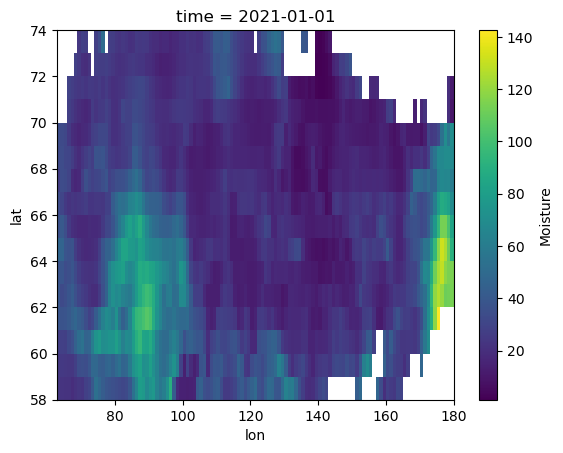

In [47]:
dataset.Moisture.sel(time='2021').plot()

In [60]:
climate_means = dataset.mean()


<xarray.Dataset>
Dimensions:    ()
Data variables:
    Tmax       float64 14.8
    Tmin       float64 4.986
    VPD        float64 0.4621
    Radiation  float64 174.1
    PDSI       float64 -1.375
    CWD        float64 17.8
    Moisture   float64 35.14
    DMC        float32 13.5
    FFMC       float32 66.57
    DC         float32 321.6
    LST        float64 278.0

In [9]:
with rio.open(f"{local_path}/PeatFire/Summaries/BA_Area_1D_2021.tif") as src:
    BA = src.read()
    profile = src.profile
area = Global_Functions.get_pixel_area(profile, path=False, profile=True)

In [ ]:
local_path = '/media/amin/DISK6T/PhD/Landsat_BA/Siberia'

BA = np.zeros((23, profile['height'], profile['width']), np.float32)
peatfire = np.zeros((23, profile['height'], profile['width']), np.float32)
peatfraction = np.zeros((23, profile['height'], profile['width']), np.float32)
peat = np.zeros((23, profile['height'], profile['width']), np.float32)
for i, year in enumerate(list(range(2001, 2024))[:]):
    print(year)
    BA[i] = rio.open(f"{local_path}/PeatFire/Summaries/BA_Area_1D_{year}.tif").read(1)
    peatfire[i] = rio.open(f"{local_path}/PeatFire/Summaries/PeatFire_Area_1D_{year}.tif").read(1)
    peat[i] = (rio.open(f"{local_path}/PeatFire/Summaries/PeatMap_Area_1D_{year}.tif").read() / area)
    
a = peatfire / BA * 100
b = (1 - peat) / peat 
peatfraction = a * b / (a * b + (100 - a)) * 100  ## As if there was the same proportion of peat vs non peat occupation
Global_Functions.write_rasterio(np.nanmean(peatfraction, 0), f"{local_path}/PeatFire/Summaries/PeatFire_Fraction_MEAN_1D.tif", profile=profile)  
Global_Functions.write_rasterio(np.nanstd(peatfraction, 0), f"{local_path}/PeatFire/Summaries/PeatFire_Fraction_STD_1D.tif", profile=profile)  



### 6.1) Aggregate to grid 

### 6.2) Aggregate to Zones

In [ ]:
climate_layers = dict(
             TerraClimate_Means={'bands': ['Tmax', 'Tmin', 'VPD', 
                                       'Radiation',  'PDSI', 
                                        'CWD','Moisture'], 'res': 1/24,
                                 'scales': [0.1, 0.1, 0.01, 0.1, 0.01, 0.1, 0.1]},
             ECMWF_CEMS_Means={'bands': ['DMC', 'FFMC'], 'res': 0.25},
             ECMWF_CEMS_DCMeans={'bands': ['DC'], 'res': 0.25},
             Gridded_LST_Anomaly={'bands': ['LST_Anomaly'], 'res': 1},
             Gridded_LST_Persistence={'bands': ['LST_Persistence'], 'res': 1},
             Gridded_LST_Mean={'bands': ['LST'], 'res': 1, 'scales': [0.02]},
                     )

In [ ]:
local_path = '/media/amin/DISK6T/PhD/Landsat_BA/Siberia'
year = 2021
grid_res = 1
ls = []
ds_mean_terraclimate = gdal.Open(f'{local_path}/PeatFire/BG_CC/data/TerraClimate_LongTermMean_Siberia.tif')
ds_std_terraclimate = gdal.Open(f'{local_path}/PeatFire/BG_CC/data/TerraClimate_LongTermSTD_Siberia.tif')
ds_mean_cems = gdal.Open(f'{local_path}/PeatFire/BG_CC/data/ECMWF_CEMS_LongTermMean_Siberia.tif')
ds_std_cems = gdal.Open(f'{local_path}/PeatFire/BG_CC/data/ECMWF_CEMS_LongTermSTD_Siberia.tif')
zones = {
        'West': [63, 58, 90, 74],
        'Center': [90, 58, 130, 74],
        'East': [130, 58, 180, 74], 
        'Arctic': [63, 66.5, 180, 74], 
        'All': [63, 58, 180, 74]}

for z, bounds in zones.items():
    print(z)
    for year in list(range(2001, 2024))[:]:
        climate = {}
        print(year)
        x0, y0 = 63, 74
        xmin, ymin, xmax, ymax = bounds
        index_lat = slice(int((ymax - y0) / -grid_res), int((ymin - y0) / -grid_res))
        index_lon = slice(int((xmin - x0) / grid_res), int((xmax - x0) / grid_res))
        area = Global_Functions.get_pixel_area(f"{local_path}/PeatFire/Summaries/BA_Area_1D_{year}.tif", path=True)
        BA = rio.open(f"{local_path}/PeatFire/Summaries/BA_Area_1D_{year}.tif").read(1)[index_lat, index_lon]
        peatfire = rio.open(f"{local_path}/PeatFire/Summaries/PeatFire_Area_1D_{year}.tif").read(1)[index_lat, index_lon]
        mask = (peatfire > 0)# & (peatfire_std > 0)
        climate['Zone'] = z
        climate['Year'] = year
        BA = BA[mask].sum()
        peatfire = peatfire[mask].sum()
        peat = rio.open(f"{local_path}/PeatFire/Summaries/PeatMap_Area_1D_{year}.tif").read(1)[index_lat, index_lon]
        peat_BGCC = rio.open(f'{local_path}/PeatFire/Summaries/BGCC-MgC_SUM_025D_PEAT_{year}.tif').read(1)
        peat_BGCC[peat_BGCC == -9999] = np.nan
        peat_BGCC = np.nansum(peat_BGCC.reshape(peat_BGCC.shape[0] // 4, 4, 
                                    peat_BGCC.shape[1] // 4, 4), axis=(1, 3))[index_lat, index_lon][mask]
        peat_BGCC = np.nansum(peat_BGCC) * 1e6 / peatfire
        
        for l in climate_layers.keys():
            # print(l)
            ds = gdal.Open(glob.glob(f'{local_path}/PeatFire/BG_CC/data/{l}/{l}_Siberia*_{year}.tif')[0])
            gt = ds.GetGeoTransform()
            index_lat = slice(int((ymax - gt[3])/gt[5]), int((ymin - gt[3])/gt[5]))
            index_lon = slice(int((xmin - gt[0])/gt[1]), int((xmax - gt[0])/gt[1]))
            for i, band in enumerate(climate_layers[l]['bands']):
                arr = ds.GetRasterBand(i+1).ReadAsArray()[index_lat, index_lon]
                climate[band] = np.nanmean(arr)
                if 'TerraClimate' in l:
                    arr = ds_mean_terraclimate.GetRasterBand(i+1).ReadAsArray()[index_lat, index_lon]
                    avrg = np.nanmean(arr)
                    arr = ds_std_terraclimate.GetRasterBand(i+1).ReadAsArray()[index_lat, index_lon]
                    std = np.nanmean(arr)
                    climate[band + '_Anomaly'] = (climate[band] - avrg) / std
                    # print(band, 'TerraClimate', avrg, std)
                elif 'ECMWF_CEMS_Means' == l:
                    arr = ds_mean_cems.GetRasterBand(i+1).ReadAsArray()[index_lat, index_lon]
                    avrg = np.nanmean(arr)
                    arr = ds_std_cems.GetRasterBand(i+1).ReadAsArray()[index_lat, index_lon]
                    std = np.nanmean(arr)
                    climate[band + '_Anomaly'] = (climate[band] - avrg) / std
                    print(band, 'CEMS', avrg, std)
                elif 'ECMWF_CEMS_DCMeans' == l:
                    arr = ds_mean_cems.GetRasterBand(4).ReadAsArray()[index_lat, index_lon]
                    avrg = np.nanmean(arr)
                    arr = ds_std_cems.GetRasterBand(4).ReadAsArray()[index_lat, index_lon]
                    std = np.nanmean(arr)
                    climate[band + '_Anomaly'] = (climate[band] - avrg) / std
                    print(band, 'DC', avrg, std)
                if 'scales' in climate_layers[l].keys():
                    # print(band, climate_layers[l]['scales'][i])
                    climate[band] = climate[band] * climate_layers[l]['scales'][i]
                    
        a = peatfire / BA * 100
        peat = peat.sum() / area[index_lat, index_lon].sum()
        print(z, peat)
        b = (1 - peat) / peat 
        peatfraction = a * b / (a * b + (100 - a)) * 100  ## As if there was the same proportion of peat vs non peat occupation

        climate['BA'] = BA * 1e-10       ## Mha
        climate['PeatFire'] = peatfire * 1e-10
        climate['PeatFraction'] = peatfraction
        climate['BGCC'] = peat_BGCC    
        ls.append(climate)

West
2001
DMC CEMS 9.765825 4.757874925622404
FFMC CEMS 64.62473 4.185103245779901
DC DC 239.13565 63.99248929200855
West 0.42079508229434676
2002
DMC CEMS 9.765825 4.757874925622404
FFMC CEMS 64.62473 4.185103245779901
DC DC 239.13565 63.99248929200855
West 0.42079508229434676
2003
DMC CEMS 9.765825 4.757874925622404
FFMC CEMS 64.62473 4.185103245779901
DC DC 239.13565 63.99248929200855
West 0.42079508229434676
2004
DMC CEMS 9.765825 4.757874925622404
FFMC CEMS 64.62473 4.185103245779901
DC DC 239.13565 63.99248929200855
West 0.42079508229434676
2005
DMC CEMS 9.765825 4.757874925622404
FFMC CEMS 64.62473 4.185103245779901
DC DC 239.13565 63.99248929200855
West 0.42079508229434676
2006
DMC CEMS 9.765825 4.757874925622404
FFMC CEMS 64.62473 4.185103245779901
DC DC 239.13565 63.99248929200855
West 0.42079508229434676
2007
DMC CEMS 9.765825 4.757874925622404
FFMC CEMS 64.62473 4.185103245779901
DC DC 239.13565 63.99248929200855
West 0.42079508229434676
2008
DMC CEMS 9.765825 4.75787492562

In [8]:
area = Global_Functions.get_pixel_area(f"{local_path}/PeatFire/Summaries/BA_Area_1D_{year}.tif", path=True)
peat = rio.open(f"{local_path}/PeatFire/Summaries/PeatMap_Area_1D_{year}.tif").read(1).sum() 
pt_prcentage = peat / area.sum() * 100
peat * 1e-12, pt_prcentage

(2.396064841728, 25.368097533806427)

In [42]:
agg_df = pd.DataFrame(ls)
agg_df['LST'] = agg_df['LST'] - 273.15
agg_df

Zone  Year       Tmax  Tmax_Anomaly      Tmin  Tmin_Anomaly       VPD  \
0    West  2001  15.460921      0.717237  7.721429      1.314844  0.427337   
1    West  2002  13.939023     -0.529959  6.695208      0.372270  0.393497   
2    West  2003  16.385411      1.474856  7.811785      1.397835  0.494982   
3    West  2004  14.755966      0.139526  6.615253      0.298833  0.444012   
4    West  2005  15.962402      1.128201  7.694738      1.290328  0.460492   
..    ...   ...        ...           ...       ...           ...       ...   
110   All  2019  16.228734      1.634989  6.057314      1.773032  0.521774   
111   All  2020  16.544927      1.917330  6.523327      2.215995  0.617640   
112   All  2021  15.752463      1.209705  5.730877      1.462743  0.503183   
113   All  2022  15.345247      0.846085  5.357078      1.107433  0.474494   
114   All  2023  16.066965      1.490538  6.078796      1.793453  0.515916   

     VPD_Anomaly   Radiation  Radiation_Anomaly  ...  FFMC_Anomaly  \
0      -0.111357  161.577046          -0.623416  ...      0.137377   
1      -0.666226  157.178667          -1.073149  ...     -0.851254   
2       0.997788  175.004411           0.749530  ...      0.569700   
3       0.162049  169.625016           0.199488  ...      0.227941   
4       0.432277  171.102808           0.350592  ...      0.411397   
..           ...         ...                ...  ...           ...   
110     1.098375  179.386531           0.673467  ...      0.682298   
111     2.733249  177.938304           0.523689  ...      1.070675   
112     0.781346  173.472267           0.061805  ...      0.692149   
113     0.292087  171.179045          -0.175363  ...      0.107360   
114     0.998485  180.670536           0.806261  ...      0.681680   

             DC  DC_Anomaly  LST_Anomaly  LST_Persistence       LST  \
0    212.931213   -0.409492    -0.242408         0.298185  5.663478   
1    188.483734   -0.791529    -0.942335         0.184730  4.586659   
2    281.405853    0.660549     0.157769         0.355035  6.131234   
3    278.885071    0.621158    -0.572498         0.205657  5.142255   
4    253.289536    0.221180     0.312786         0.320598  6.352209   
..          ...         ...          ...              ...       ...   
110  355.400482    0.534650     0.424944         0.372824  5.497944   
111  361.362579    0.612719     0.958453         0.489684  6.209343   
112  360.624115    0.603049     0.108199         0.332477  5.001931   
113  318.254517    0.048250     0.267626         0.329481  5.245822   
114  332.722687    0.237700     1.134561         0.487295  6.325332   

            BA  PeatFire  PeatFraction         BGCC  
0     0.068770  0.030328     52.059692  2973.621338  
1     0.095347  0.037319     46.956143  2972.577212  
2     0.530817  0.282051     60.947063  3344.284400  
3     1.023064  0.457433     52.677414  2995.093350  
4     1.210485  0.499349     49.148890  3053.135544  
..         ...       ...           ...          ...  
110   7.433626  2.718919     62.916199  3090.126847  
111   9.287784  4.057666     69.534954  2991.915004  
112  10.574772  3.836113     62.613572  3043.505631  
113   1.707494  0.483232     53.730011  3027.396954  
114   2.813517  1.013414     62.352954  3106.175231  

[115 rows x 29 columns]

In [11]:
agg_df.describe()

Year        Tmax  Tmax_Anomaly        Tmin  Tmin_Anomaly  \
count   115.000000  115.000000    115.000000  115.000000    115.000000   
mean   2012.000000   14.665252      0.623057    5.020971      0.855920   
std       6.662279    1.362212      0.714671    1.514907      0.617946   
min    2001.000000   10.868759     -1.284892    2.528562     -0.700635   
25%    2006.000000   13.837699      0.229247    3.869698      0.489474   
50%    2012.000000   14.825113      0.528548    4.762364      0.758117   
75%    2018.000000   15.462255      1.010175    5.935964      1.097583   
max    2023.000000   17.940498      2.547759    9.184992      2.741352   

              VPD  VPD_Anomaly   Radiation  Radiation_Anomaly        PDSI  \
count  115.000000   115.000000  115.000000         115.000000  115.000000   
mean     0.460584     0.364710  172.850178           0.179917   -1.397528   
std      0.064088     0.876379    7.139560           0.626262    1.668548   
min      0.308054    -1.190219  153.922571          -1.437032   -5.637776   
25%      0.416593    -0.151429  167.470452          -0.188836   -2.403021   
50%      0.462724     0.258998  173.473141           0.230096   -1.375964   
75%      0.498391     0.791352  178.080132           0.584286   -0.348570   
max      0.669676     3.963258  189.209856           2.160689    2.557338   

       ...  FFMC_Anomaly          DC    DC_Anomaly  LST_Anomaly  \
count  ...    115.000000  115.000000  1.150000e+02   115.000000   
mean   ...      0.319324  321.913452 -5.429442e-10    -0.008680   
std    ...      0.476559   55.626431  4.649995e-01     0.641805   
min    ...     -0.940243  185.587616 -1.126482e+00    -1.725564   
25%    ...     -0.003137  290.327377 -2.997577e-01    -0.391485   
50%    ...      0.316930  327.915070 -5.709004e-02    -0.066483   
75%    ...      0.616430  359.348068  3.502500e-01     0.363413   
max    ...      1.765498  443.588654  1.179713e+00     1.764823   

       LST_Persistence         LST          BA    PeatFire  PeatFraction  \
count       115.000000  115.000000  115.000000  115.000000    115.000000   
mean          0.314921    4.655552    1.945780    0.671107     61.654576   
std           0.097733    1.248953    2.303675    0.830672     10.901490   
min           0.085052    1.703230    0.013300    0.006551     33.657964   
25%           0.257359    3.885173    0.225540    0.080883     53.748633   
50%           0.298185    4.643130    1.015141    0.337662     62.143962   
75%           0.361987    5.306485    2.958544    1.038157     70.171294   
max           0.630178    8.363447   10.574772    4.057666     84.671244   

              BGCC  
count   115.000000  
mean   2974.464954  
std     140.520908  
min    2559.308717  
25%    2885.230727  
50%    2988.675508  
75%    3071.858915  
max    3344.284400  

[8 rows x 35 columns]

In [ ]:
agg_df.to_csv(f'{local_path}/PeatFire/BG_CC/data/Data_Climate_Analysis_All.csv')
agg_df.query("Zone != 'Arctic'").to_csv(f'{local_path}/PeatFire/BG_CC/data/Data_Path_Analysis.csv')
agg_df.query("Zone not in ['East', 'West', 'Center']").to_csv(f'{local_path}/PeatFire/BG_CC/data/Data_Climate_Plots.csv')

In [34]:
local_path = '/media/amin/DISK6T/PhD/Landsat_BA/Siberia'
agg_df = pd.read_csv(f'{local_path}/PeatFire/BG_CC/data/Data_Climate_Analysis_All.csv', index_col='Unnamed: 0')
agg_df

Zone  Year       Tmax  Tmax_Anomaly      Tmin  Tmin_Anomaly       VPD  \
0    West  2001  15.460921      0.717237  7.721429      1.314844  0.427337   
1    West  2002  13.939023     -0.529959  6.695208      0.372270  0.393497   
2    West  2003  16.385411      1.474856  7.811785      1.397835  0.494982   
3    West  2004  14.755966      0.139526  6.615253      0.298833  0.444012   
4    West  2005  15.962402      1.128201  7.694738      1.290328  0.460492   
..    ...   ...        ...           ...       ...           ...       ...   
110   All  2019  16.228734      1.634989  6.057314      1.773032  0.521774   
111   All  2020  16.544927      1.917330  6.523327      2.215995  0.617640   
112   All  2021  15.752463      1.209705  5.730877      1.462743  0.503183   
113   All  2022  15.345247      0.846085  5.357078      1.107433  0.474494   
114   All  2023  16.066965      1.490538  6.078796      1.793453  0.515916   

     VPD_Anomaly   Radiation  Radiation_Anomaly  ...  FFMC_Anomaly         DC  \
0      -0.111357  161.577046          -0.623416  ...      0.137377  212.93121   
1      -0.666226  157.178667          -1.073149  ...     -0.851254  188.48373   
2       0.997788  175.004411           0.749530  ...      0.569700  281.40585   
3       0.162049  169.625016           0.199488  ...      0.227941  278.88507   
4       0.432277  171.102808           0.350592  ...      0.411397  253.28954   
..           ...         ...                ...  ...           ...        ...   
110     1.098375  179.386531           0.673467  ...      0.682298  355.40048   
111     2.733249  177.938304           0.523689  ...      1.070675  361.36258   
112     0.781346  173.472267           0.061805  ...      0.692149  360.62410   
113     0.292087  171.179045          -0.175363  ...      0.107360  318.25452   
114     0.998485  180.670536           0.806261  ...      0.681680  332.72270   

     DC_Anomaly  LST_Anomaly  LST_Persistence       LST         BA  PeatFire  \
0     -0.409492    -0.242408         0.298185  5.663478   0.068770  0.030328   
1     -0.791529    -0.942335         0.184730  4.586659   0.095347  0.037319   
2      0.660549     0.157769         0.355035  6.131234   0.530817  0.282051   
3      0.621158    -0.572498         0.205657  5.142255   1.023064  0.457433   
4      0.221180     0.312786         0.320598  6.352209   1.210485  0.499349   
..          ...          ...              ...       ...        ...       ...   
110    0.534650     0.424944         0.372824  5.497944   7.433626  2.718919   
111    0.612719     0.958453         0.489684  6.209343   9.287784  4.057666   
112    0.603049     0.108199         0.332477  5.001931  10.574772  3.836113   
113    0.048250     0.267626         0.329481  5.245822   1.707494  0.483232   
114    0.237700     1.134561         0.487295  6.325332   2.813517  1.013414   

     PeatFraction         BGCC  
0       52.059692  2973.621338  
1       46.956143  2972.577212  
2       60.947063  3344.284400  
3       52.677414  2995.093350  
4       49.148890  3053.135544  
..            ...          ...  
110     62.916199  3090.126847  
111     69.534954  2991.915004  
112     62.613572  3043.505631  
113     53.730011  3027.396954  
114     62.352954  3106.175231  

[115 rows x 29 columns]

<AxesSubplot: >

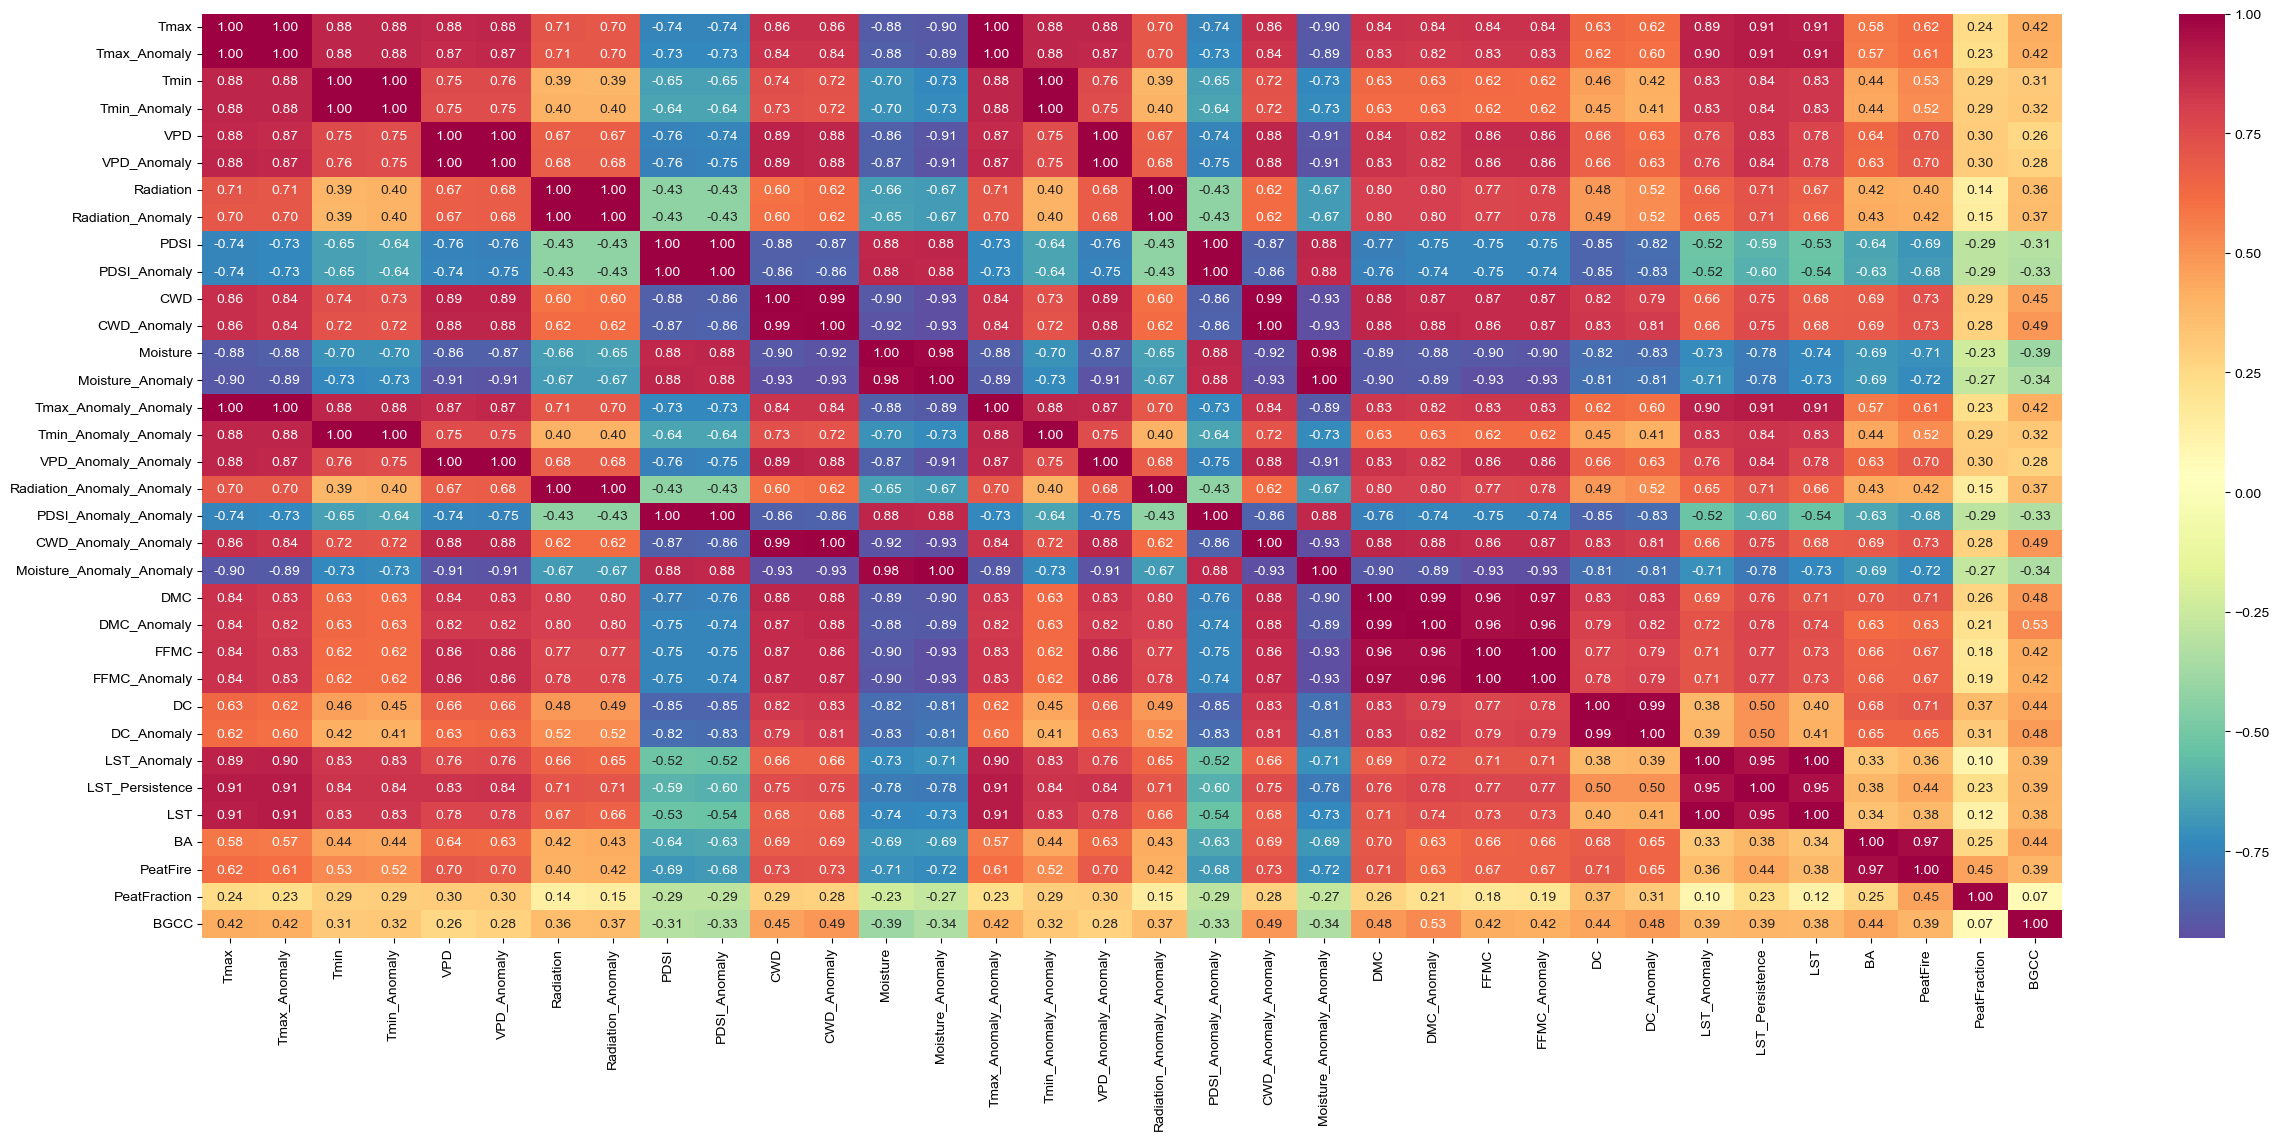

In [12]:
fig, ax = plt.subplots(figsize=(30, 12))
# agg_df['PeatFire'] = np.log(agg_df['PeatFire'])
corrMatrix = agg_df.loc[agg_df.Zone == 'All'].drop(columns=['Zone', 'Year']).corr(method='pearson')
sns.heatmap(corrMatrix, annot=True, fmt='.02f', cmap='Spectral_r')

<AxesSubplot: >

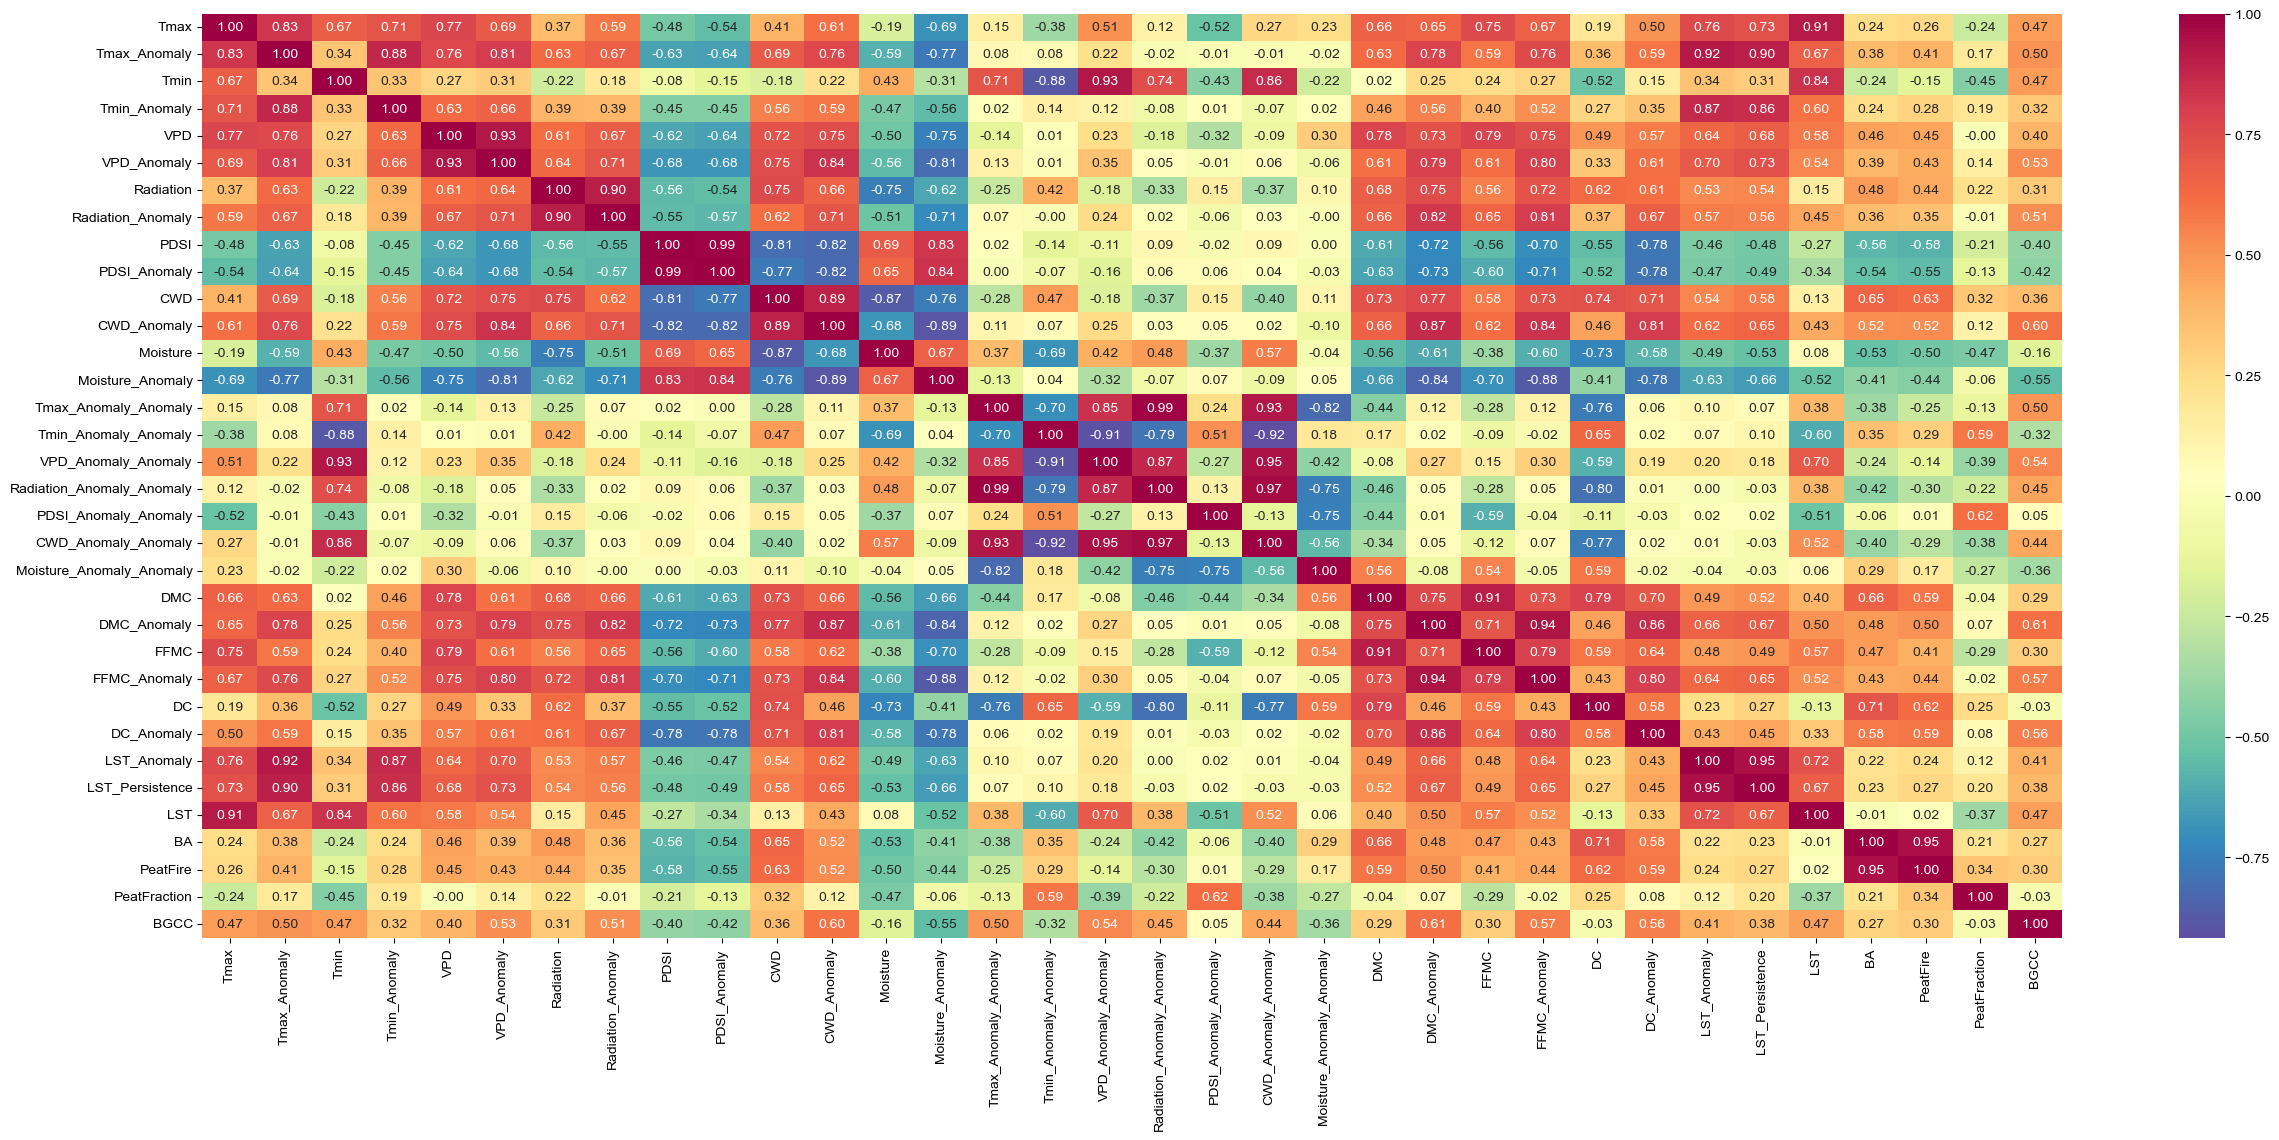

In [13]:
fig, ax = plt.subplots(figsize=(30, 12))
# agg_df['PeatFire'] = np.log(agg_df['PeatFire'])
corrMatrix = agg_df.loc[~np.isin(agg_df.Zone, ('All', 'Arctic'))].drop(columns=['Zone', 'Year']).corr(method='pearson')
sns.heatmap(corrMatrix, annot=True, fmt='.02f', cmap='Spectral_r')

#### CWD with DC

In [11]:
np.unique(agg_df.Zone)

array(['All', 'Center', 'East', 'West'], dtype=object)

/tmp/ipykernel_4084729/2445197259.py:42: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
/tmp/ipykernel_4084729/2445197259.py:66: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)


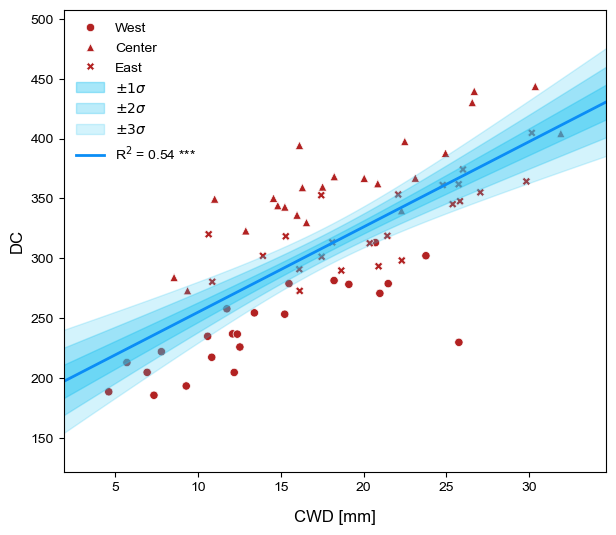

In [15]:
masked_df = agg_df.query("Zone not in ['All', 'Arctic']").copy()
# masked_df['PeatFire'] = masked_df.PeatFire * 1e-9
drivers = {
          "CWD": 'CWD [mm]',
        #   "CWD_Anomaly": "CWD Anomaly"
            }
response = {
          "DC": 'DC',
        #   "DC_Anomaly": "DC Anomaly"
            }
confidence = [[r"$\pm 1\sigma$", 0.3173, 0.4],
             [r"$\pm 2\sigma$", 0.0455, 0.3],
             [r"$\pm 3\sigma$",0.0027, 0.2]]
rows, cols = int(np.ceil(len(drivers)/2)), (len(drivers)>1)*2 + (len(drivers)==1)*1
fig, axes = plt.subplots(rows, cols, figsize=(7*cols, 6*rows))
for i, (d, resp) in enumerate(list(zip(drivers.keys(), response.keys()))[:]):
    try:
        ax = axes.flatten()[i]
    except:
        ax = axes
    x, y = masked_df[d], masked_df[resp] 
    # ax.scatter(x, y, 
    #    marker='o', color='firebrick', edgecolor='firebrick', zorder=3)
    sns.scatterplot(data=masked_df, x=d, y=resp, ax=ax,
           markers=["o", "^", "X"], 
           style='Zone',
        #    hue='Zone', 
                    # palette=reversed(colors)
            color='firebrick'
                   )
    x_edge = (x.max() - x.min()) * 0.1
    ax.set_xlim(x.min()-x_edge, x.max()+x_edge)
    x_curve = np.linspace(x.min()-x_edge, x.max()+x_edge, 100)  # More points for a smooth curve
    model = sm.OLS(y, sm.add_constant(x)).fit()        
    y_fit = model.predict(sm.add_constant(x))
    p_value = model.pvalues[1]
    slope = model.params.iloc[1]
    intercept = model.params.iloc[0]
    r2 = metrics.r2_score(y, y_fit)
    # print(r2)
    pos_int = intercept >= 0
    sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
    
    predictions = model.get_prediction(sm.add_constant(x_curve))
    y_curve = predictions.predicted
    for l, val, t in confidence:
        lower = predictions.conf_int(alpha=val)[:, 0] 
        upper = predictions.conf_int(alpha=val)[:, 1] 
        ax.fill_between(x_curve, lower, upper, alpha=t, color='#23c3f1', label=l)
    
    texts = []
    # for j, year in enumerate(masked_df['Year']):
    #     # plt.annotate(year, (x[i], y[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    #     texts.append(ax.text(x.iloc[j], y.iloc[j], year, fontsize=10, ha='center'));
    
    # adjust_text(texts, ax=ax, expand=(1.2, 1.2), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
    #             arrowprops=dict(arrowstyle='->', color='black'), # ensure the labeling is clear by adding arrows
    #             );
    y_edge = (upper.max() - lower.min()) * 0.1
    ax.set_ylim(min(lower.min(), y.min())-y_edge, max(y.max(), upper.max())+y_edge)
    lab = 'R$^2$ = %.2f %s' %(r2, sig)                                                            
    ax.plot(x_curve, y_curve, color='#0a8df6', label=lab, lw=2)
    
    ax.set_xlabel(drivers[d], size=12, labelpad=12)
    ax.set_ylabel(response[resp], size=12)
    log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
    legend = ax.legend(frameon=False, loc=log_loc)
    legend._legend_box.sep = 10
    # ax.text(-0.1, 1.05, f'{string.ascii_lowercase[i]})', transform=ax.transAxes, fontsize=14, fontweight='bold', ha='center')


#### Peatfires with Summer means

/tmp/ipykernel_4084729/3499442506.py:37: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
/tmp/ipykernel_4084729/3499442506.py:72: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
/tmp/ipykernel_4084729/3499442506.py:37: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
/tmp/ipykernel_4084729/3499442506.py:72: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
/tmp/ipykernel_4084729/34994

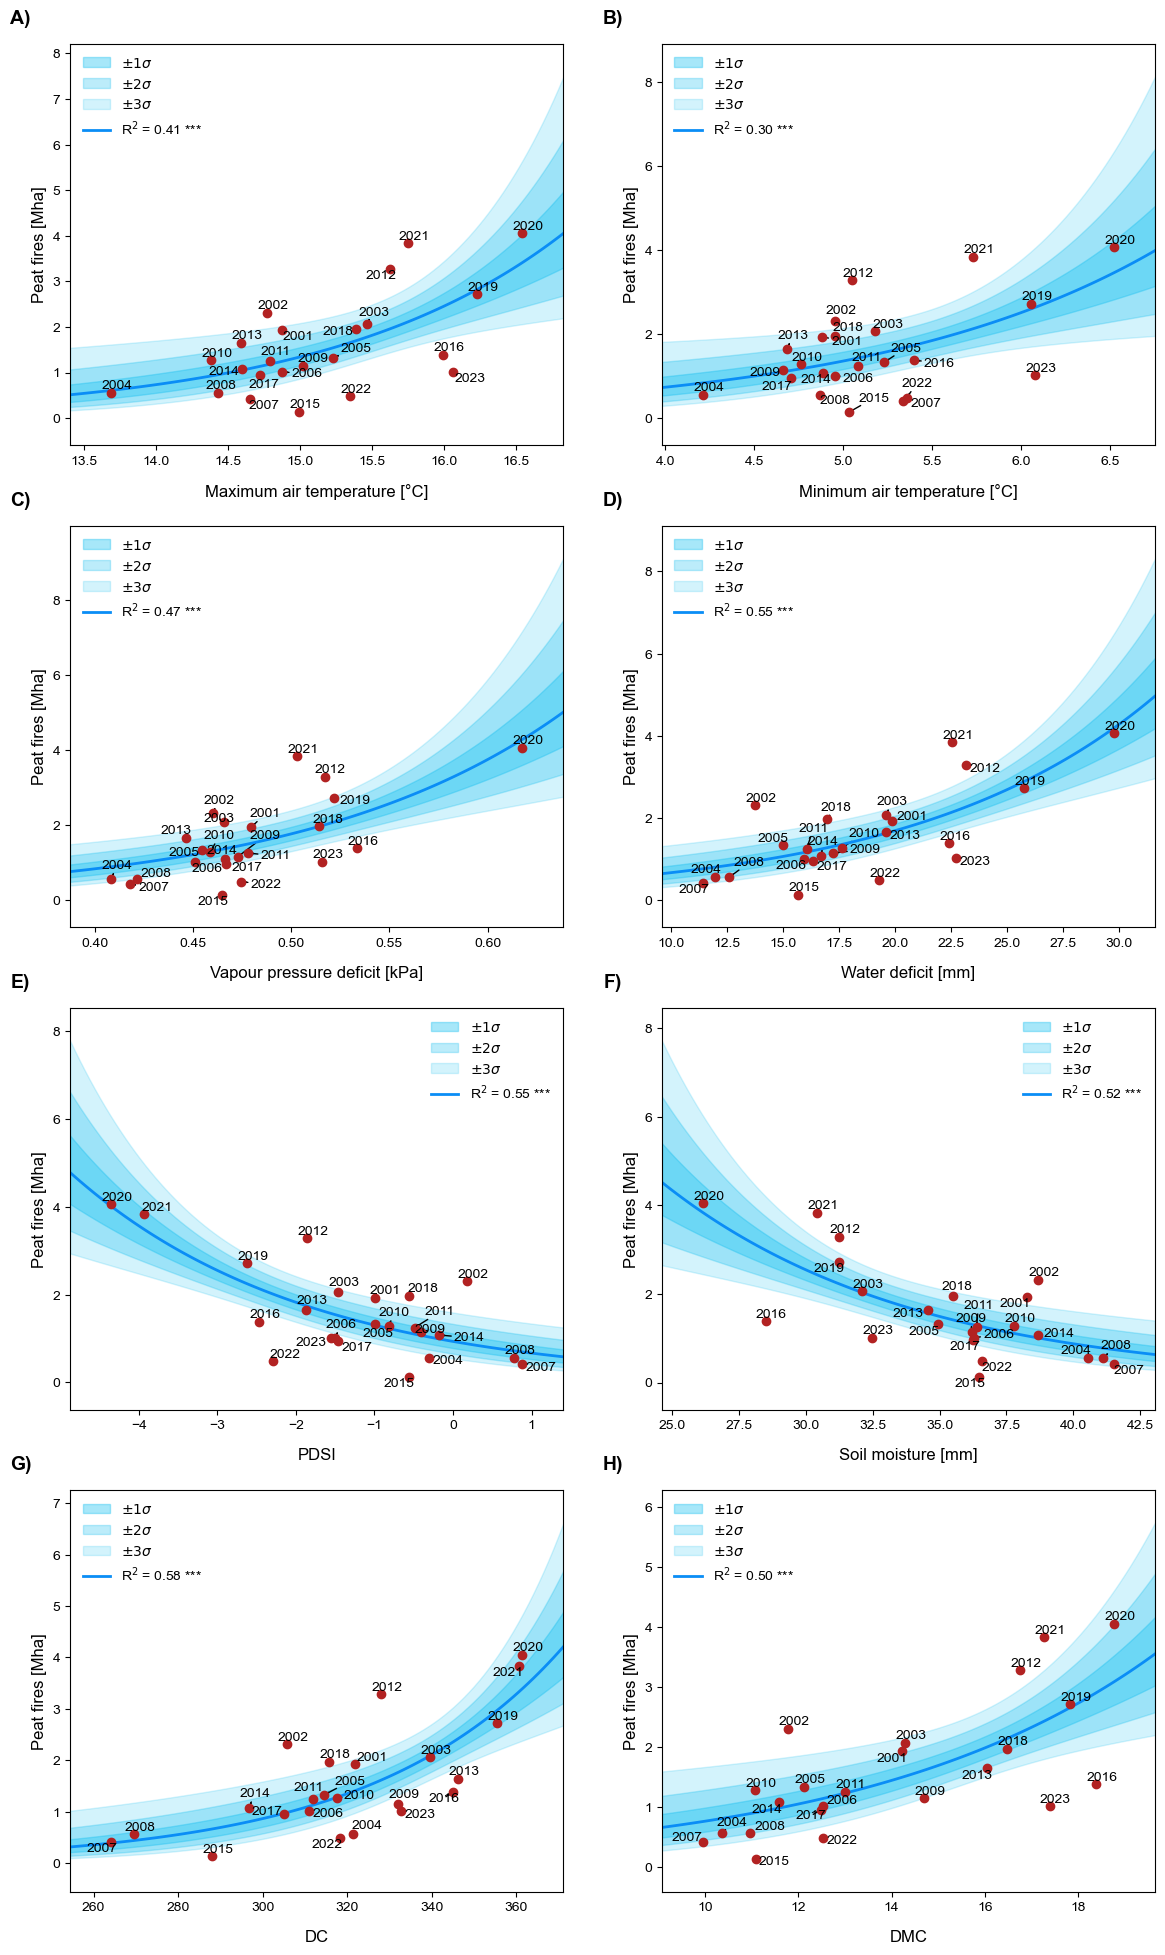

In [45]:
masked_df = agg_df.query("Zone == 'All'").copy()
# masked_df['PeatFire'] = masked_df.PeatFire * 1e-9
drivers = {"Tmax": 'Maximum air temperature [°C]',
           "Tmin": 'Minimum air temperature [°C]',      
            "VPD": 'Vapour pressure deficit [kPa]',
          "CWD": 'Water deficit [mm]',
          "PDSI": 'PDSI',
          "Moisture": 'Soil moisture [mm]',
          "DC": 'DC',
           "DMC": 'DMC',
          # "BA": 'Total burned area [Mha]',
            }
confidence = [[r"$\pm 1\sigma$", 0.3173, 0.4],
             [r"$\pm 2\sigma$", 0.0455, 0.3],
             [r"$\pm 3\sigma$",0.0027, 0.2]]
fig, axes = plt.subplots(4, 2, figsize=(14, 24))
for i, d in enumerate(list(drivers.keys())[:]):
    ax = axes.flatten()[i]
    x, y = masked_df[d], masked_df.PeatFire 
    ax.scatter(x, y, 
       marker='o', color='firebrick', edgecolor='firebrick', zorder=3)
    x_edge = (x.max() - x.min()) * 0.1
    ax.set_xlim(x.min()-x_edge, x.max()+x_edge)
    x_curve = np.linspace(x.min()-x_edge, x.max()+x_edge, 100)  # More points for a smooth curve
    model = sm.GLM(y, sm.add_constant(x), 
           family=sm.families.Gaussian(link=sm.families.links.Log())).fit()
    if d == 'BA':
        model = sm.OLS(y, sm.add_constant(x)).fit()        
    y_fit = model.predict(sm.add_constant(x))
    # p_value = stats.chi2.sf(model.pearson_chi2, model.df_model)
    p_value = model.pvalues[1]
    slope = model.params.iloc[1]
    intercept = model.params.iloc[0]
    r2 = metrics.r2_score(y, y_fit)
    # print(r2)
    pos_int = intercept >= 0
    sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
    predictions = model.get_prediction(sm.add_constant(x_curve))
    y_curve = predictions.predicted
    for l, val, t in confidence:
        lower = predictions.conf_int(alpha=val)[:, 0] 
        upper = predictions.conf_int(alpha=val)[:, 1] 
        ax.fill_between(x_curve, lower, upper, alpha=t, color='#23c3f1', label=l)
    
    texts = []
    for j, year in enumerate(masked_df['Year']):
        # plt.annotate(year, (x[i], y[i]), textcoords="offset points", xytext=(0, 10), ha='center')
        texts.append(ax.text(x.iloc[j], y.iloc[j], year, fontsize=10, ha='center'));
    
    adjust_text(texts, ax=ax, expand=(1.2, 1.2), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
                arrowprops=dict(arrowstyle='->', color='black'), # ensure the labeling is clear by adding arrows
                );
    y_edge = (upper.max() - lower.min()) * 0.1
    ax.set_ylim(min(lower.min(), y.min())-y_edge, max(y.max(), upper.max())+y_edge)
    if d == 'BA':
        ax.set_ylim(ax.get_xlim()[0], None)
        lab = 'R$^2$ = {:.2f} {} \ny = {:.2f} x{}{} {:.2f} [Mha]'.format(r2, sig, slope, " +" * pos_int, " -" * (not pos_int), abs(intercept))
    else:
        lab = 'R$^2$ = %.2f %s' %(r2, sig)                                                            
    ax.plot(x_curve, y_curve, color='#0a8df6', label=lab, lw=2)
    
    ax.set_xlabel(drivers[d], size=12, labelpad=12)
    ax.set_ylabel('Peat fires [Mha]', size=12)
    
    # slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    # rmse = metrics.mean_squared_error(x, y, squared=False)
    # mae = metrics.mean_absolute_error(x, y)
    # x2 = np.linspace(*ax.get_xlim(), 100)
    # line = slope * x2 + intercept
    # pos_int = intercept >= 0
    # sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
    log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
    # ax.plot(x2, line, label='R$^2$ = %.2f %s' %(r_value**2, sig), color='blue', linestyle='--', dashes=(2, 2))
    legend = ax.legend(frameon=False, loc=log_loc)
    legend._legend_box.sep = 10
    ax.text(-0.1, 1.05, f'{string.ascii_uppercase[i]})', transform=ax.transAxes, fontsize=14, fontweight='bold', ha='center')
    # plt.savefig(f'{local_path}/Plots/Peatfires_Climate.jpeg', 
    #            dpi= 500, bbox_inches='tight', pad_inches=1*1/2.54)

#### Peatfires with anomalies

/tmp/ipykernel_4084729/2695571345.py:37: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
/tmp/ipykernel_4084729/2695571345.py:76: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
/tmp/ipykernel_4084729/2695571345.py:37: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
/tmp/ipykernel_4084729/2695571345.py:76: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
/tmp/ipykernel_4084729/26955

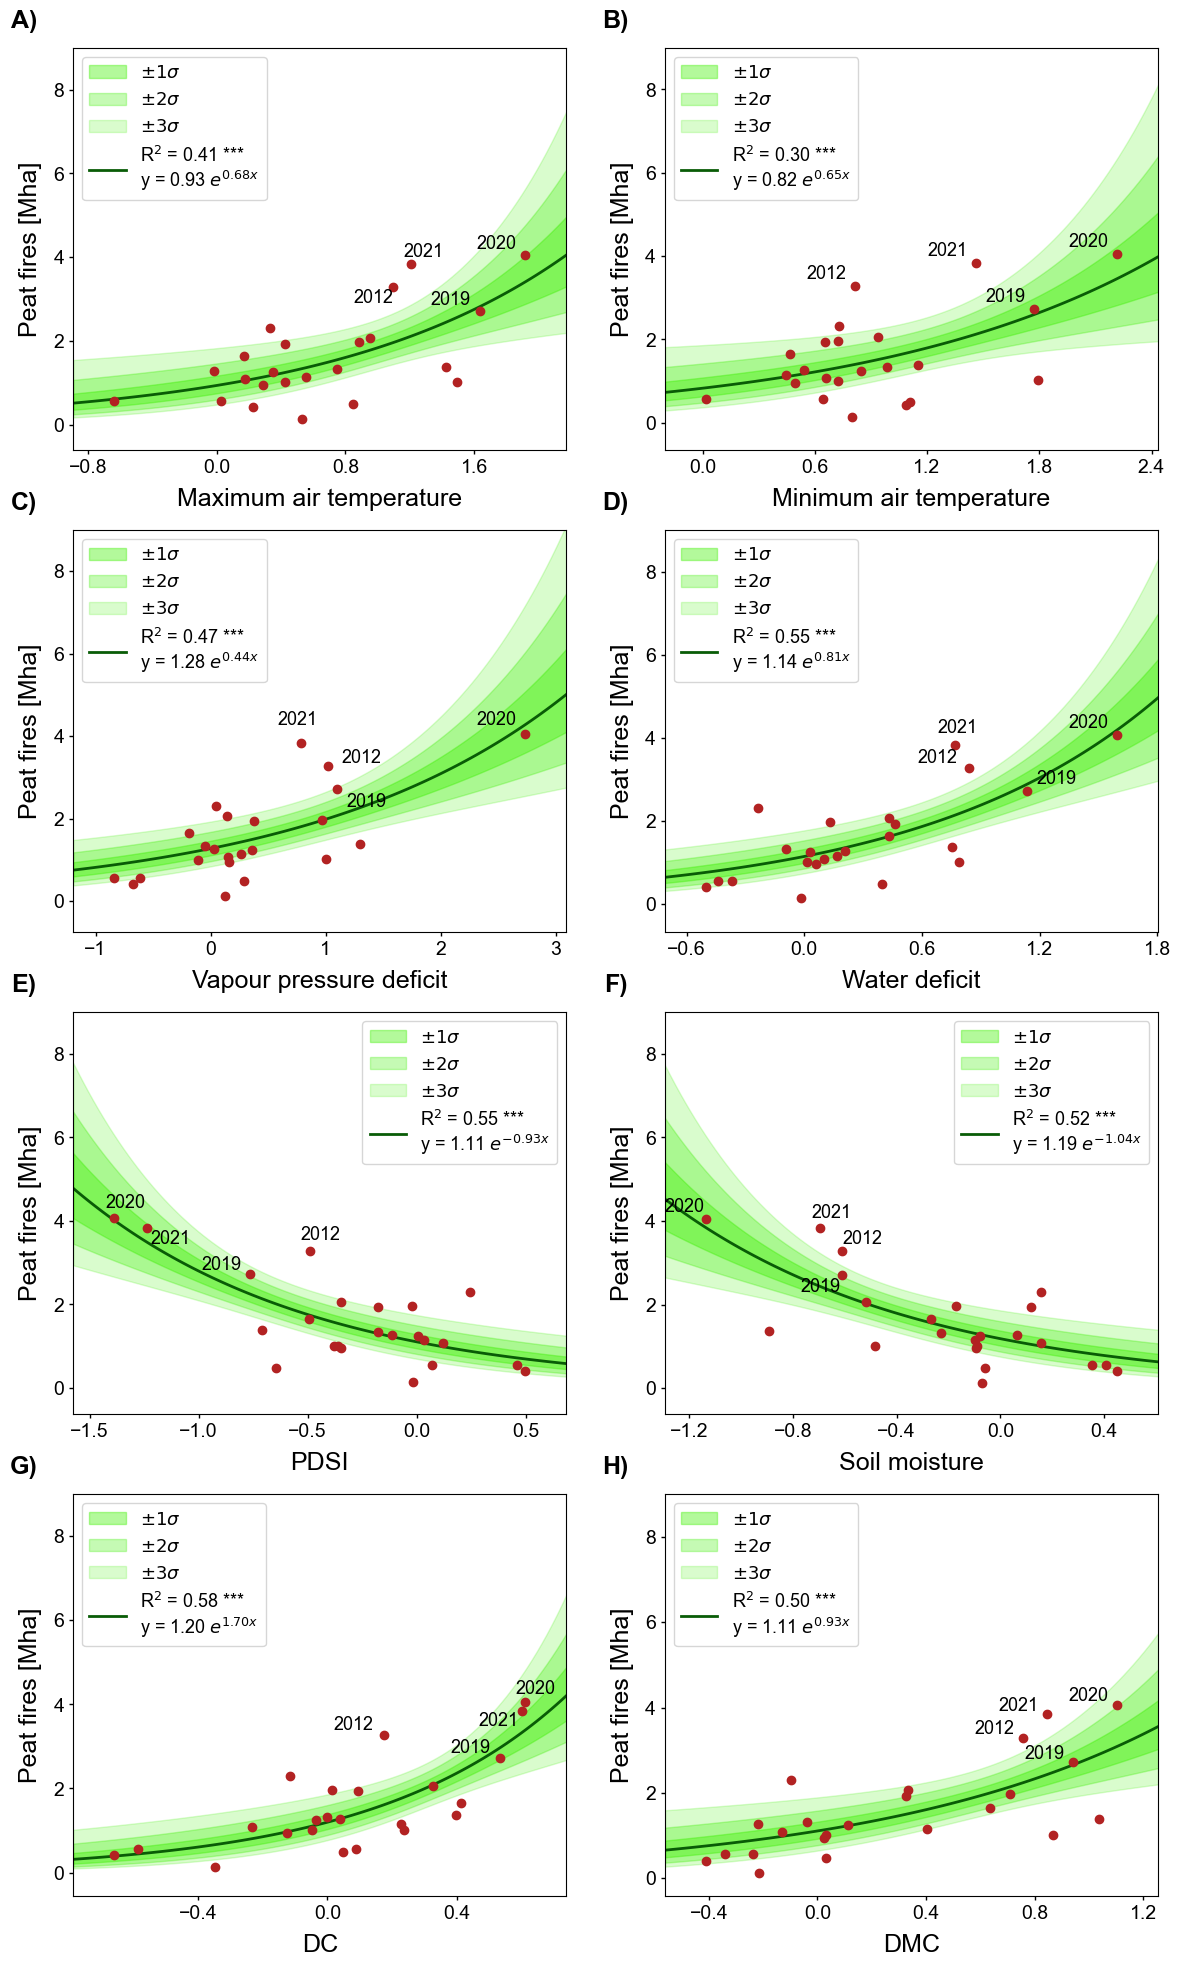

In [44]:
masked_df = agg_df.query("Zone == 'All'").copy()
# masked_df['PeatFire'] = masked_df.PeatFire * 1e-9
drivers = {"Tmax_Anomaly": 'Maximum air temperature',
           "Tmin_Anomaly": 'Minimum air temperature',      
            "VPD_Anomaly": 'Vapour pressure deficit',
          "CWD_Anomaly": 'Water deficit',
          "PDSI_Anomaly": 'PDSI',
          "Moisture_Anomaly": 'Soil moisture',
          "DC_Anomaly": 'DC',
           "DMC_Anomaly": 'DMC',
          # "BA": 'Total burned area [Mha]',
            }
confidence = [[r"$\pm 1\sigma$", 0.3173, 0.4],
             [r"$\pm 2\sigma$", 0.0455, 0.3],
             [r"$\pm 3\sigma$",0.0027, 0.2]]
fig, axes = plt.subplots(4, 2, figsize=(14, 24))
for i, d in enumerate(list(drivers.keys())[:]):
    ax = axes.flatten()[i]
    x, y = masked_df[d], masked_df.PeatFire 
    ax.scatter(x, y, 
       marker='o', color='firebrick', edgecolor='firebrick', zorder=3)
    x_edge = (x.max() - x.min()) * 0.1
    ax.set_xlim(x.min()-x_edge, x.max()+x_edge)
    x_curve = np.linspace(x.min()-x_edge, x.max()+x_edge, 100)  # More points for a smooth curve
    model = sm.GLM(y, sm.add_constant(x), 
           family=sm.families.Gaussian(link=sm.families.links.Log())).fit()
    if d == 'BA':
        model = sm.OLS(y, sm.add_constant(x)).fit()        
    y_fit = model.predict(sm.add_constant(x))
    p_value = model.pvalues[1]
    slope = model.params.iloc[1]
    intercept = model.params.iloc[0]
    equation = "y = %.2f $e^{%.2fx}$" %(np.exp(intercept), slope)
    r2 = metrics.r2_score(y, y_fit)
    # print(r2)
    pos_int = intercept >= 0
    sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
    
    predictions = model.get_prediction(sm.add_constant(x_curve))
    y_curve = predictions.predicted
    for l, val, t in confidence:
        lower = predictions.conf_int(alpha=val)[:, 0] 
        upper = predictions.conf_int(alpha=val)[:, 1] 
        ax.fill_between(x_curve, lower, upper, alpha=t, color='#41f007', label=l)
    
    texts = []
    labelled = masked_df.loc[np.isin(masked_df.Year, [2012, 2019, 2020, 2021]), 'Year']
    for j, year in zip(labelled.index, labelled):
        # plt.annotate(year, (x[i], y[i]), textcoords="offset points", xytext=(0, 10), ha='center')
        texts.append(ax.text(x.loc[j], y.loc[j], year, fontsize=13, ha='center'));
    
    adjust_text(texts, ax=ax, expand=(1.5, 1.5), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
                arrowprops=dict(arrowstyle='->', color='none'), # ensure the labeling is clear by adding arrows
                );
    y_edge = (upper.max() - lower.min()) * 0.1
    ax.set_ylim(min(lower.min(), y.min())-y_edge, max(y.max(), upper.max())+y_edge)
    if d == 'BA':
        ax.set_ylim(ax.get_xlim()[0], None)
        lab = 'R$^2$ = {:.2f} {} \ny = {:.2f} x{}{} {:.2f} [Mha]'.format(r2, sig, slope, " +" * pos_int, " -" * (not pos_int), abs(intercept))
    else:
        lab = 'R$^2$ = %.2f %s \n%s' %(r2, sig, equation)                                                            
    ax.plot(x_curve, y_curve, color='#095c06', label=lab, lw=2)
    
    ax.set_xlabel(drivers[d], size=18, labelpad=8)
    ax.set_ylabel('Peat fires [Mha]', size=18, labelpad=8)
    ax.tick_params(labelsize = 14, size=3, width=1)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_ylim(None, 9)
    # slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    # rmse = metrics.mean_squared_error(x, y, squared=False)
    # mae = metrics.mean_absolute_error(x, y)
    # x2 = np.linspace(*ax.get_xlim(), 100)
    # line = slope * x2 + intercept
    # pos_int = intercept >= 0
    # sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
    log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
    # ax.plot(x2, line, label='R$^2$ = %.2f %s' %(r_value**2, sig), color='blue', linestyle='--', dashes=(2, 2))
    legend = ax.legend(frameon=True, loc=log_loc, fontsize=13)
    legend._legend_box.sep = 10
    ax.text(-0.1, 1.05, f'{string.ascii_uppercase[i]})', transform=ax.transAxes, fontsize=18, fontweight='bold', ha='center')
    plt.savefig(f'{local_path}/Plots/Peatfires_Climate-Anomalies.jpeg', 
               dpi= 500, bbox_inches='tight', pad_inches=1*1/2.54)

/tmp/ipykernel_4084729/2016901318.py:43: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
/tmp/ipykernel_4084729/2016901318.py:79: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
/tmp/ipykernel_4084729/2016901318.py:43: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
/tmp/ipykernel_4084729/2016901318.py:79: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)


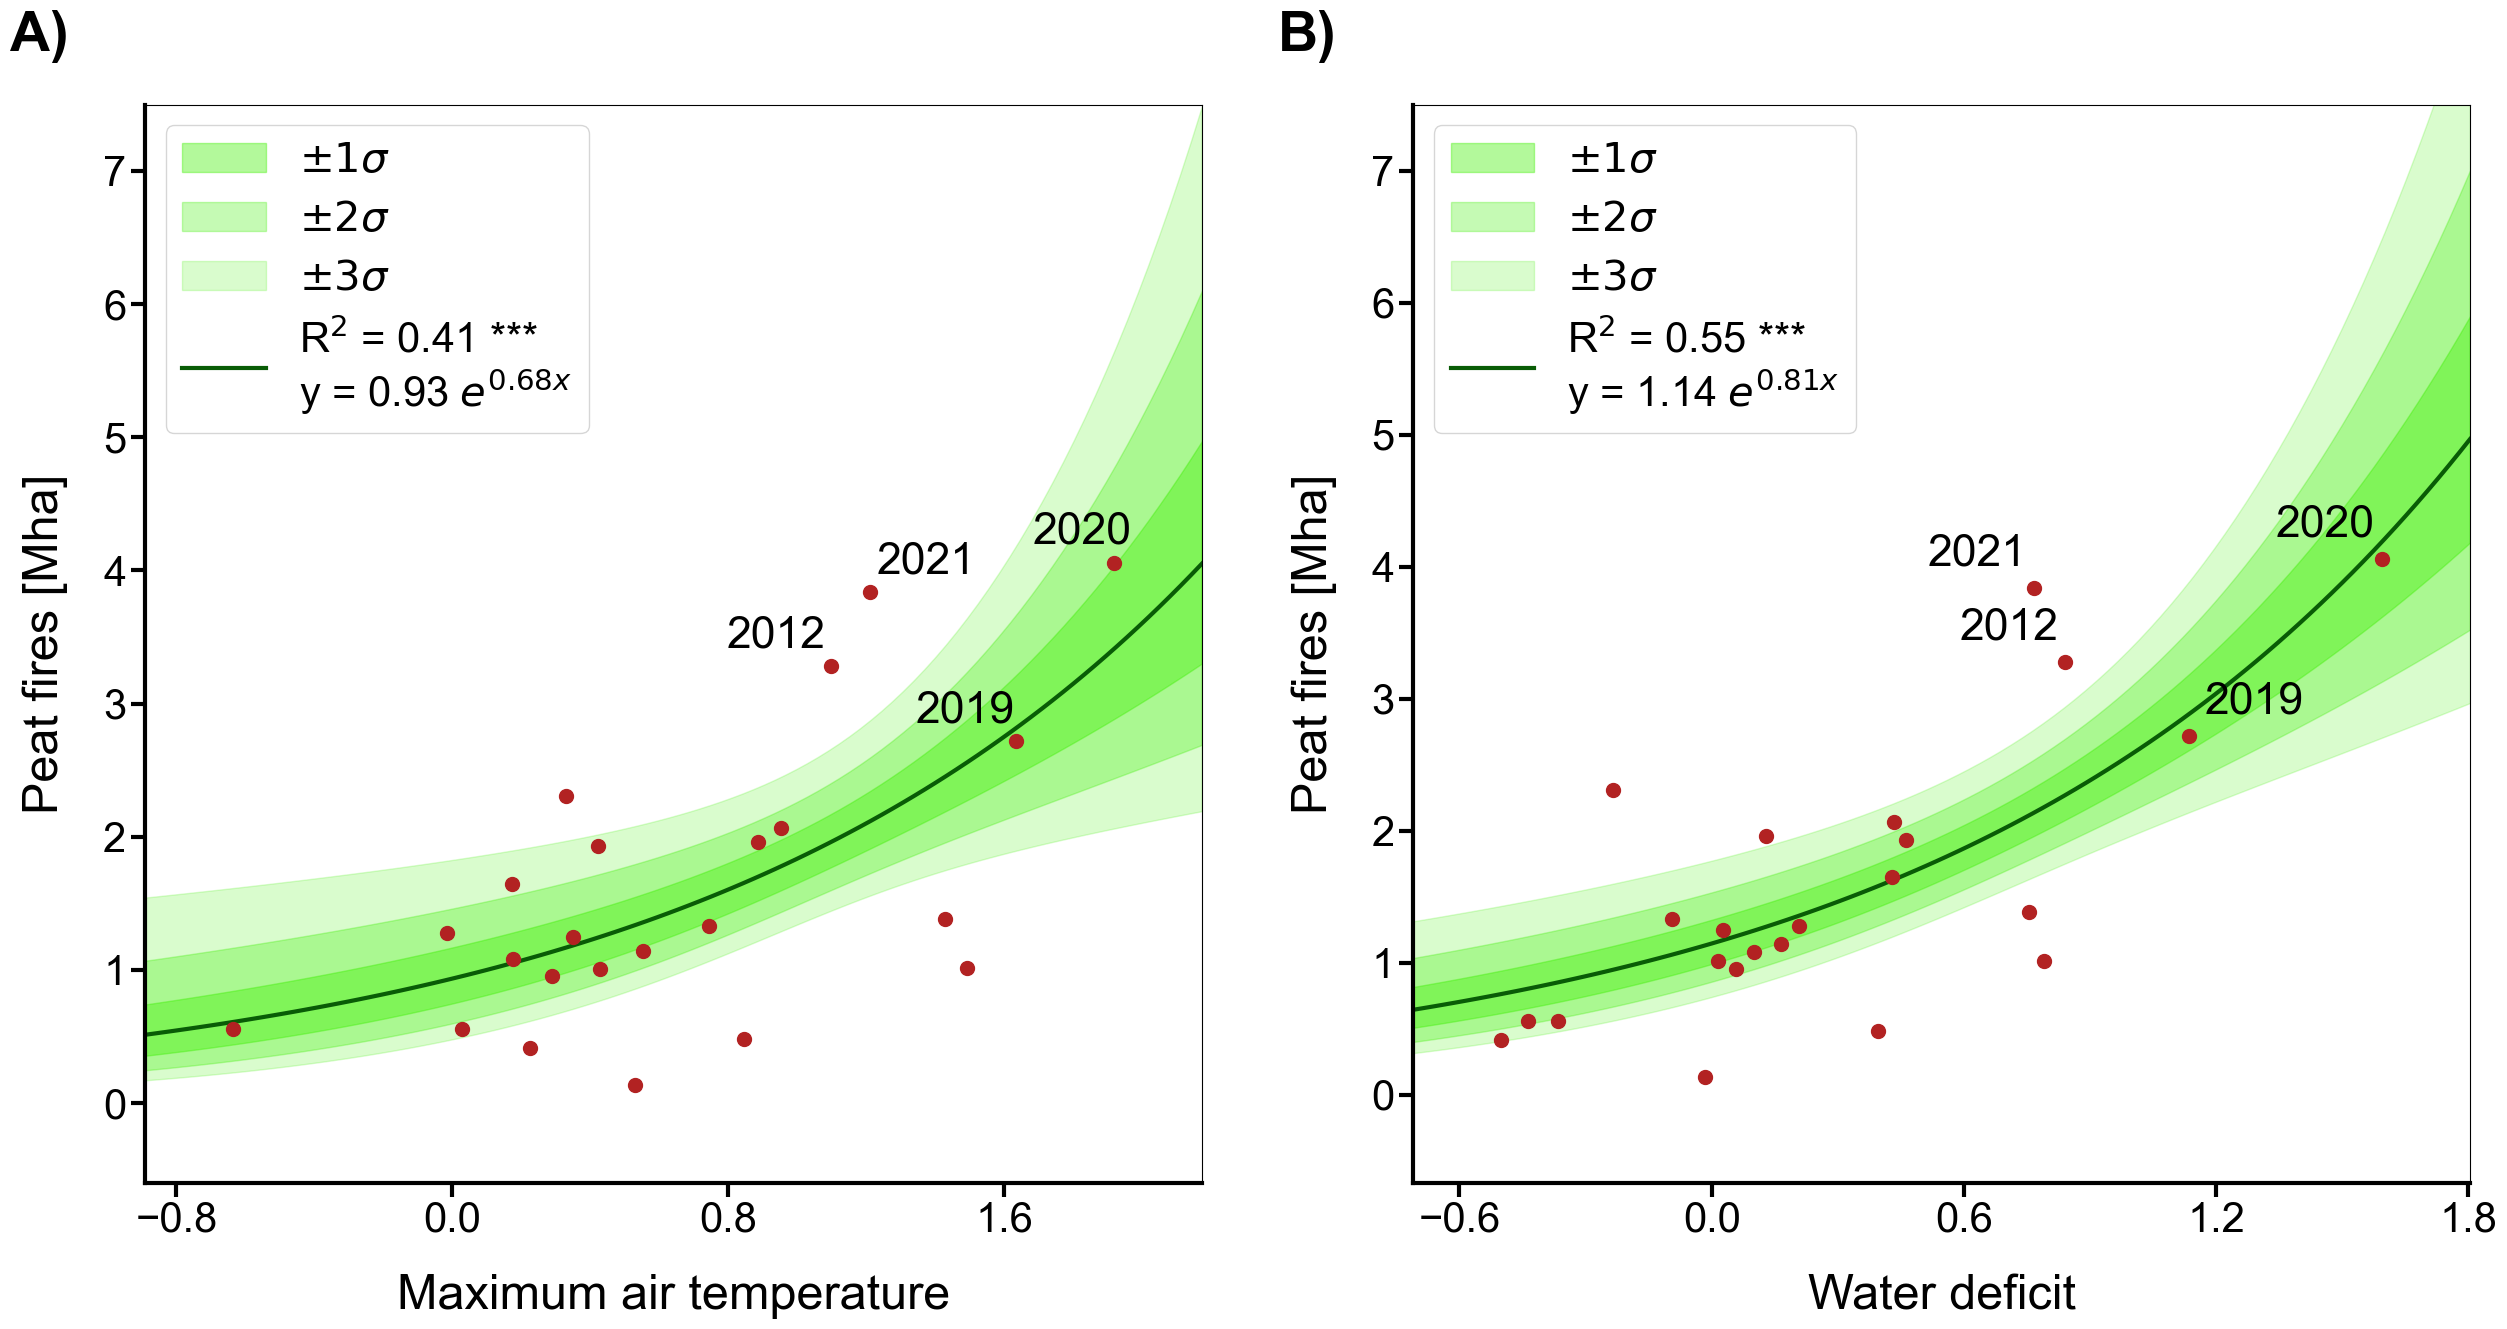

In [ ]:
masked_df = agg_df.query("Zone == 'All'").copy()
# masked_df['PeatFire'] = masked_df.PeatFire * 1e-9
drivers = {"Tmax_Anomaly": 'Maximum air temperature',
          "CWD_Anomaly": 'Water deficit'
            }
confidence = [[r"$\pm 1\sigma$", 0.3173, 0.4],
             [r"$\pm 2\sigma$", 0.0455, 0.3],
             [r"$\pm 3\sigma$",0.0027, 0.2]]
fig, axes = plt.subplots(1, 2, figsize=(30, 14))
for i, d in enumerate(list(drivers.keys())[:]):
    ax = axes.flatten()[i]
    x, y = masked_df[d], masked_df.PeatFire 

    ax.scatter(x, y, 
       marker='o', color='firebrick', edgecolor='firebrick', zorder=3, s=100)
    x_edge = (x.max() - x.min()) * 0.1
    ax.set_xlim(x.min()-x_edge, x.max()+x_edge)
    x_curve = np.linspace(x.min()-x_edge, x.max()+x_edge, 100)  # More points for a smooth curve

    model = sm.GLM(y, sm.add_constant(x), 
           family=sm.families.Gaussian(link=sm.families.links.Log())).fit() 
    y_fit = model.predict(sm.add_constant(x))
    p_value = model.pvalues[1]
    slope = model.params.iloc[1]
    intercept = model.params.iloc[0]
    equation = "y = %.2f $e^{%.2fx}$" %(np.exp(intercept), slope)
    r2 = metrics.r2_score(y, y_fit)
    # print(r2)
    pos_int = intercept >= 0
    sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
    
    predictions = model.get_prediction(sm.add_constant(x_curve))
    y_curve = predictions.predicted
    for l, val, t in confidence:
        lower = predictions.conf_int(alpha=val)[:, 0] 
        upper = predictions.conf_int(alpha=val)[:, 1] 
        ax.fill_between(x_curve, lower, upper, alpha=t, color='#41f007', label=l)
    
    texts = []
    labelled = masked_df.loc[np.isin(masked_df.Year, [2012, 2019, 2020, 2021]), 'Year']
    for j, year in zip(labelled.index, labelled):
        # plt.annotate(year, (x[i], y[i]), textcoords="offset points", xytext=(0, 10), ha='center')
        texts.append(ax.text(x.loc[j], y.loc[j], year, fontsize=32, ha='center'));
    
    adjust_text(texts, ax=ax, expand=(1.5, 1.5), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
                arrowprops=dict(arrowstyle='->', color='none'), # ensure the labeling is clear by adding arrows
                );
    y_edge = (upper.max() - lower.min()) * 0.1
    ax.set_ylim(min(lower.min(), y.min())-y_edge, max(y.max(), upper.max())+y_edge)
    lab = 'R$^2$ = %.2f %s \n%s' %(r2, sig, equation)                                                            
    ax.plot(x_curve, y_curve, color='#095c06', label=lab, lw=3)
    
    ax.set_xlabel(drivers[d], size=35, labelpad=25)
    ax.set_ylabel('Peat fires [Mha]', size=35, labelpad=25)
    ax.tick_params(labelsize = 30, size=10, width=3)
    ax.spines[['bottom', 'left']].set_linewidth(3)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_ylim(None, 7.5)
    # slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    # rmse = metrics.mean_squared_error(x, y, squared=False)
    # mae = metrics.mean_absolute_error(x, y)
    # x2 = np.linspace(*ax.get_xlim(), 100)
    # line = slope * x2 + intercept
    # pos_int = intercept >= 0
    # sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
    log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
    # ax.plot(x2, line, label='R$^2$ = %.2f %s' %(r_value**2, sig), color='blue', linestyle='--', dashes=(2, 2))
    legend = ax.legend(frameon=True, loc=log_loc, fontsize=30)
    legend._legend_box.sep = 10
    ax.text(-0.1, 1.05, f'{string.ascii_uppercase[i]})', transform=ax.transAxes, fontsize=40, fontweight='bold', ha='center')
    plt.savefig(f'{local_path}/Plots/Peatfires_Climate-Anomalies_Abstract.jpeg', 
               dpi= 500, bbox_inches='tight', pad_inches=1*1/2.54)

#### Arctic

/tmp/ipykernel_4084729/921236313.py:38: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
/tmp/ipykernel_4084729/921236313.py:78: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
/tmp/ipykernel_4084729/921236313.py:38: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
/tmp/ipykernel_4084729/921236313.py:78: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
/tmp/ipykernel_4084729/921236313

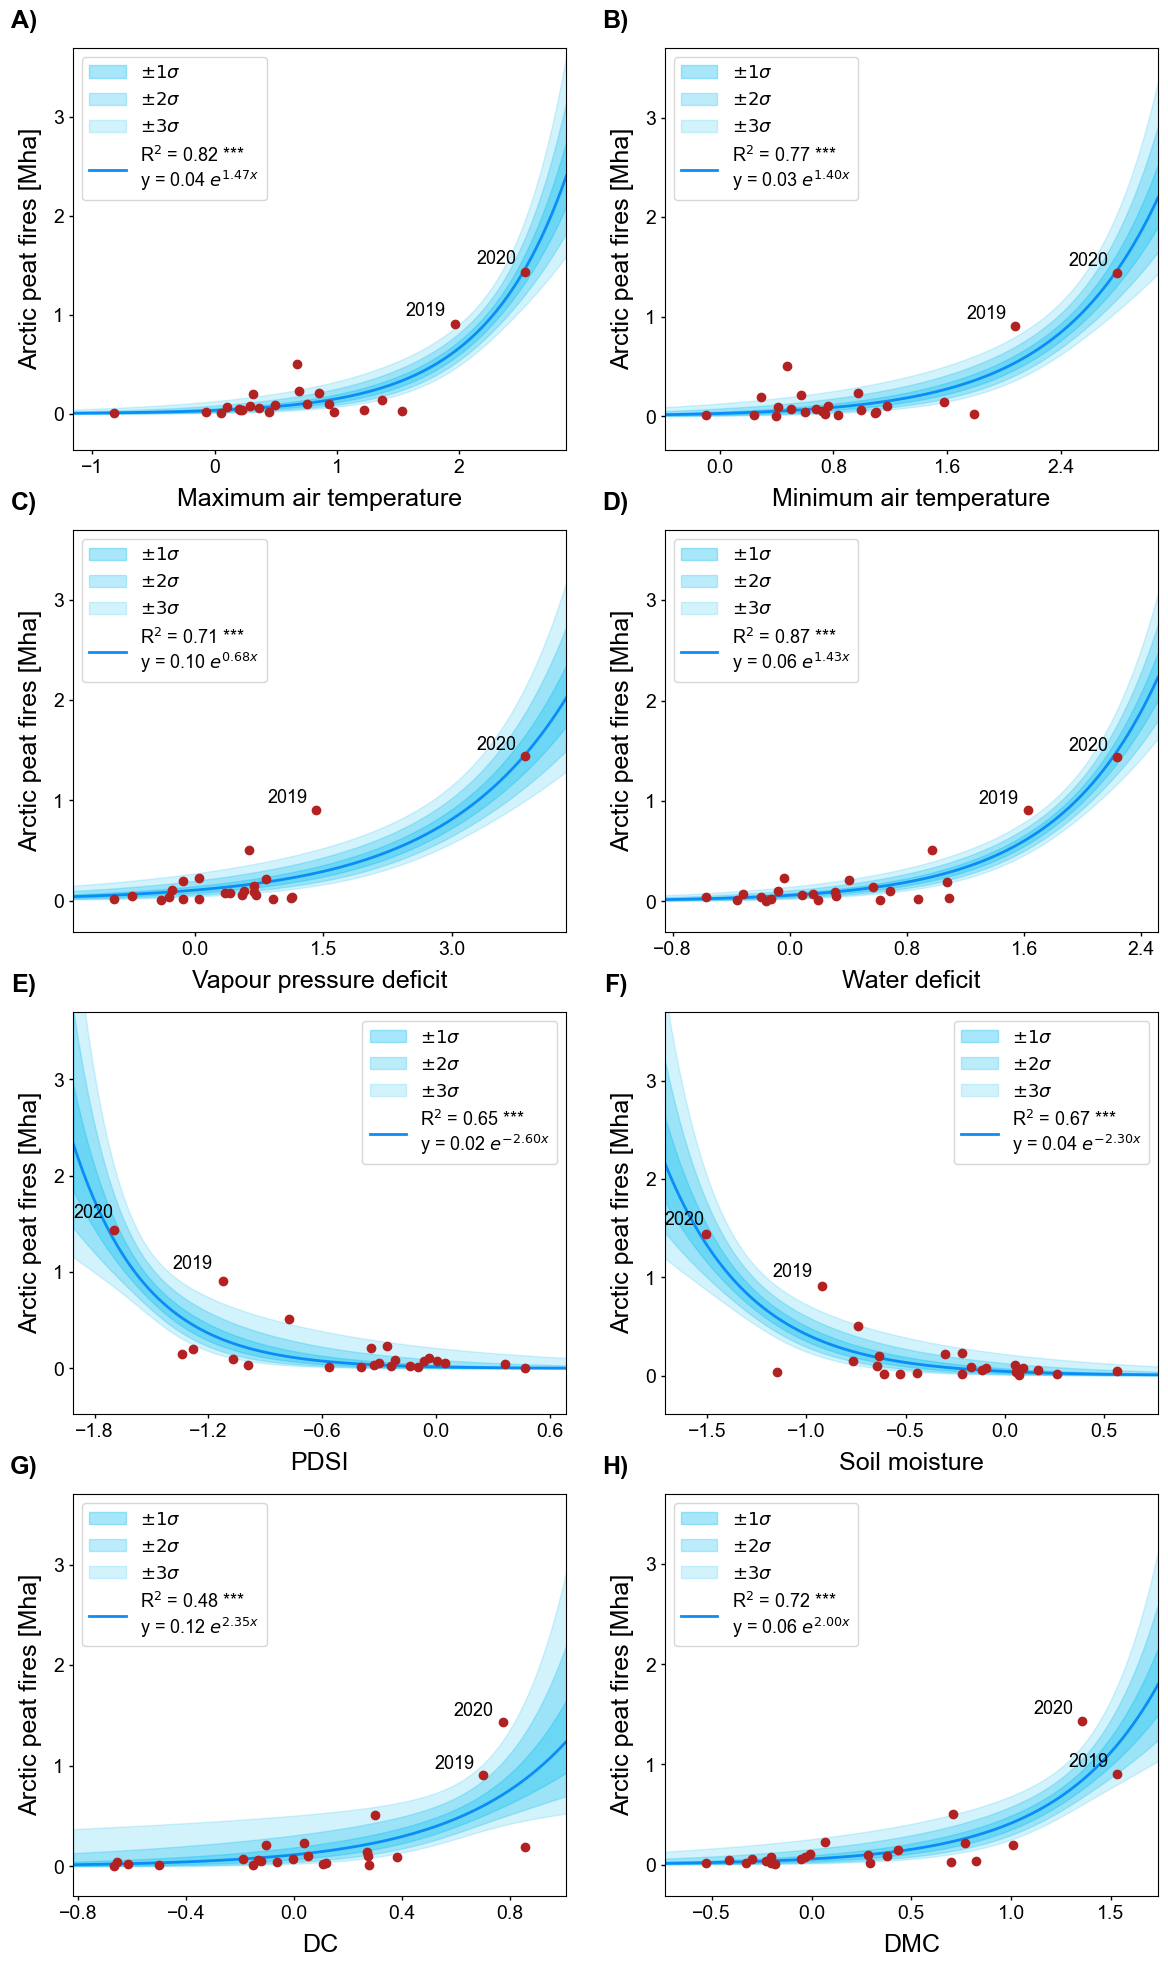

In [ ]:
masked_df = agg_df.query("Zone == 'Arctic'").copy()
# masked_df['PeatFire'] = masked_df.PeatFire * 1e-9
drivers = {"Tmax_Anomaly": 'Maximum air temperature',
           "Tmin_Anomaly": 'Minimum air temperature',      
            "VPD_Anomaly": 'Vapour pressure deficit',
          "CWD_Anomaly": 'Water deficit',
          "PDSI_Anomaly": 'PDSI',
          "Moisture_Anomaly": 'Soil moisture',
          "DC_Anomaly": 'DC',
           "DMC_Anomaly": 'DMC',
          # "BA": 'Total burned area [Mha]',
            }
confidence = [[r"$\pm 1\sigma$", 0.3173, 0.4],
             [r"$\pm 2\sigma$", 0.0455, 0.3],
             [r"$\pm 3\sigma$",0.0027, 0.2]]
fig, axes = plt.subplots(4, 2, figsize=(14, 24))
for i, d in enumerate(list(drivers.keys())[:]):
    ax = axes.flatten()[i]
    x, y = masked_df[d], masked_df.PeatFire 
    ax.scatter(x, y, 
       marker='o', color='firebrick', edgecolor='firebrick', zorder=3)
    x_edge = (x.max() - x.min()) * 0.1
    ax.set_xlim(x.min()-x_edge, x.max()+x_edge)
    x_curve = np.linspace(x.min()-x_edge, x.max()+x_edge, 100)  # More points for a smooth curve
    model = sm.GLM(y, sm.add_constant(x), 
           family=sm.families.Gaussian(link=sm.families.links.Log())).fit()
    if d == 'BA':
        model = sm.OLS(y, sm.add_constant(x)).fit()        
    y_fit = model.predict(sm.add_constant(x))
    p_value = model.pvalues[1]
    slope = model.params.iloc[1]
    intercept = model.params.iloc[0]
    equation = "y = %.2f $e^{%.2fx}$" %(np.exp(intercept), slope)
    r2 = metrics.r2_score(y, y_fit)
    # print(r2)
    pos_int = intercept >= 0
    sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
    
    predictions = model.get_prediction(sm.add_constant(x_curve))
    y_curve = predictions.predicted
    for l, val, t in confidence:
        lower = predictions.conf_int(alpha=val)[:, 0] 
        upper = predictions.conf_int(alpha=val)[:, 1] 
        ax.fill_between(x_curve, lower, upper, alpha=t, color='#23c3f1', label=l)
    
    texts = []
    labelled = masked_df.loc[np.isin(masked_df.Year, [2019, 2020]), 'Year']
    for j, year in zip(labelled.index, labelled):
        # plt.annotate(year, (x[i], y[i]), textcoords="offset points", xytext=(0, 10), ha='center')
        texts.append(ax.text(x.loc[j], y.loc[j], year, fontsize=13, ha='center'));
    
    adjust_text(texts, ax=ax, expand=(1.5, 1.5), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
                arrowprops=dict(arrowstyle='->', color='none'), # ensure the labeling is clear by adding arrows
                );
    y_edge = (upper.max() - lower.min()) * 0.1
    ax.set_ylim(min(lower.min(), y.min())-y_edge, max(y.max(), upper.max())+y_edge)
    if d == 'BA':
        ax.set_ylim(ax.get_xlim()[0], None)
        lab = 'R$^2$ = {:.2f} {} \ny = {:.2f} x{}{} {:.2f} [Mha]'.format(r2, sig, slope, " +" * pos_int, " -" * (not pos_int), abs(intercept))
    else:
        lab = 'R$^2$ = %.2f %s \n%s' %(r2, sig, equation)                                                            
    ax.plot(x_curve, y_curve, color='#0a8df6', label=lab, lw=2)
    
    ax.set_xlabel(drivers[d], size=18, labelpad=8)
    ax.set_ylabel('Arctic peat fires [Mha]', size=18, labelpad=8)
    ax.tick_params(labelsize = 14, size=3, width=1)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_ylim(None, 3.7)
    ax.set_yticks(range(4))
    # slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    # rmse = metrics.mean_squared_error(x, y, squared=False)
    # mae = metrics.mean_absolute_error(x, y)
    # x2 = np.linspace(*ax.get_xlim(), 100)
    # line = slope * x2 + intercept
    # pos_int = intercept >= 0
    # sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
    log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
    # ax.plot(x2, line, label='R$^2$ = %.2f %s' %(r_value**2, sig), color='blue', linestyle='--', dashes=(2, 2))
    legend = ax.legend(frameon=True, loc=log_loc, fontsize=13)
    legend._legend_box.sep = 10
    ax.text(-0.1, 1.05, f'{string.ascii_uppercase[i]})', transform=ax.transAxes, fontsize=18, fontweight='bold', ha='center')
    plt.savefig(f'{local_path}/Plots/Peatfires_Arctic_Climate-Anomalies.jpeg', 
               dpi= 500, bbox_inches='tight', pad_inches=1*1/2.54)

/tmp/ipykernel_4084729/3196273480.py:28: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
/tmp/ipykernel_4084729/3196273480.py:67: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
/tmp/ipykernel_4084729/3196273480.py:28: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
/tmp/ipykernel_4084729/3196273480.py:67: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)


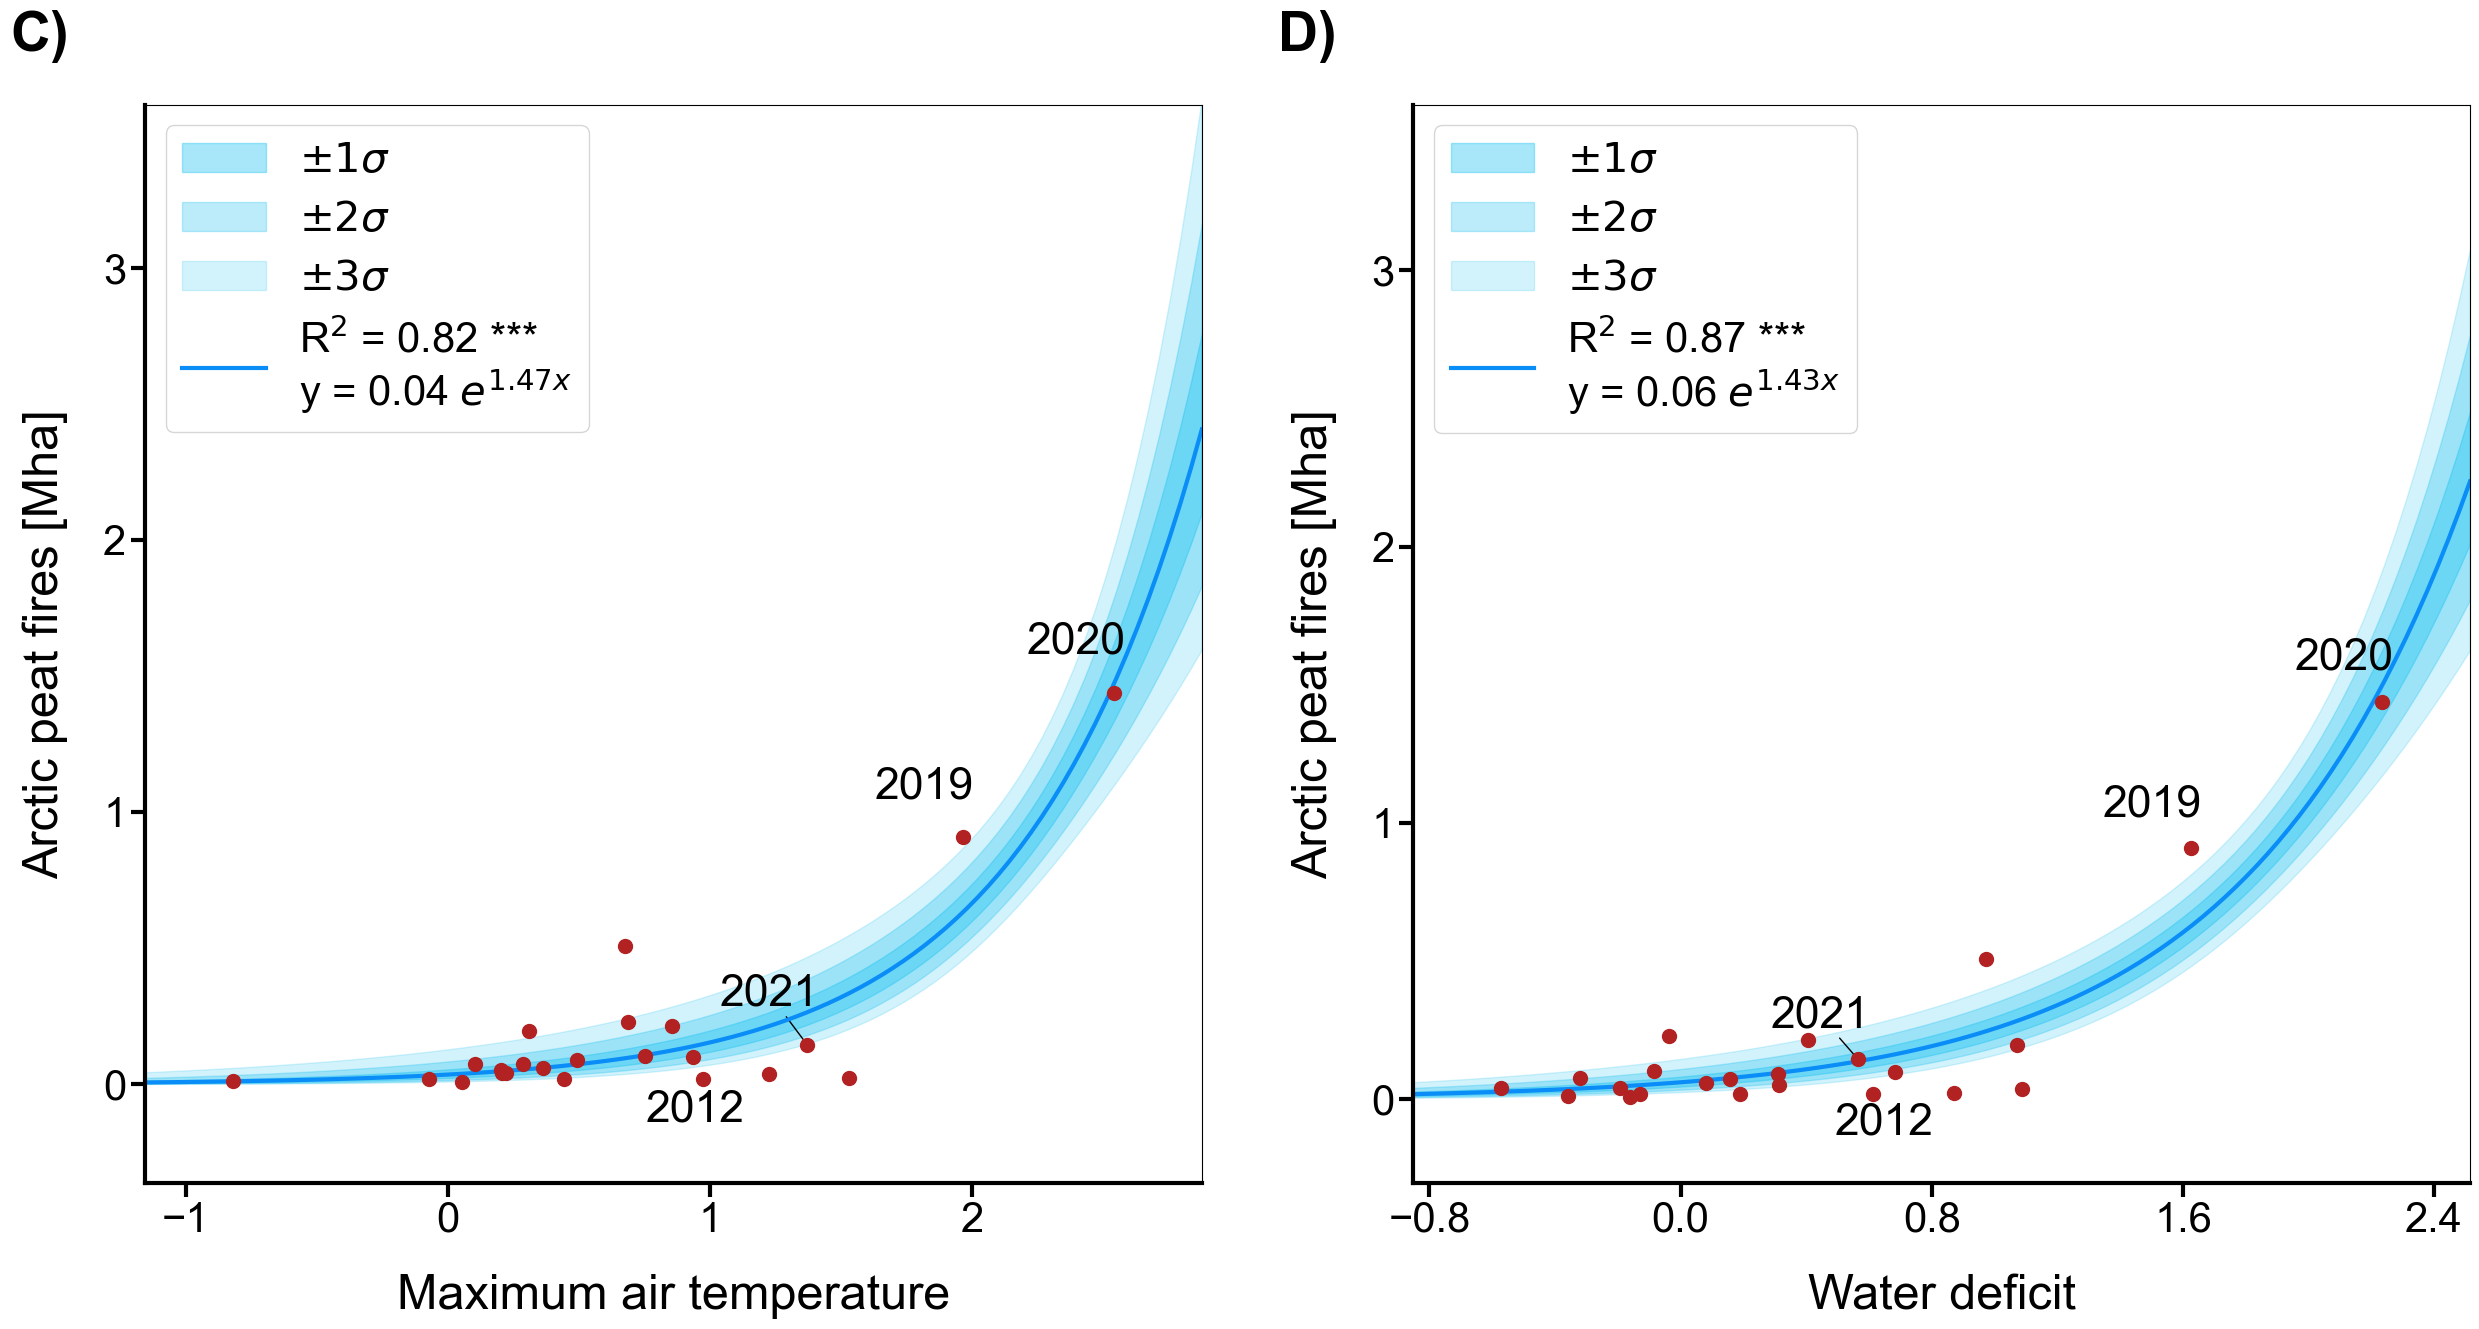

In [23]:
masked_df = agg_df.query("Zone == 'Arctic'").copy()
# masked_df['PeatFire'] = masked_df.PeatFire * 1e-9
drivers = {"Tmax_Anomaly": 'Maximum air temperature',
          "CWD_Anomaly": 'Water deficit'
            }
confidence = [[r"$\pm 1\sigma$", 0.3173, 0.4],
             [r"$\pm 2\sigma$", 0.0455, 0.3],
             [r"$\pm 3\sigma$",0.0027, 0.2]]
fig, axes = plt.subplots(1, 2, figsize=(30, 14))
for i, d in enumerate(list(drivers.keys())[:]):
    ax = axes.flatten()[i]
    x, y = masked_df[d], masked_df.PeatFire 
    ax.scatter(x, y, 
       marker='o', color='firebrick', edgecolor='firebrick', zorder=3, s=100)
    x_edge = (x.max() - x.min()) * 0.1
    ax.set_xlim(x.min()-x_edge, x.max()+x_edge)
    x_curve = np.linspace(x.min()-x_edge, x.max()+x_edge, 100)  # More points for a smooth curve
    model = sm.GLM(y, sm.add_constant(x), 
           family=sm.families.Gaussian(link=sm.families.links.Log())).fit() 
    y_fit = model.predict(sm.add_constant(x))
    p_value = model.pvalues[1]
    slope = model.params.iloc[1]
    intercept = model.params.iloc[0]
    equation = "y = %.2f $e^{%.2fx}$" %(np.exp(intercept), slope)
    r2 = metrics.r2_score(y, y_fit)
    # print(r2)
    pos_int = intercept >= 0
    sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
    
    predictions = model.get_prediction(sm.add_constant(x_curve))
    y_curve = predictions.predicted
    for l, val, t in confidence:
        lower = predictions.conf_int(alpha=val)[:, 0] 
        upper = predictions.conf_int(alpha=val)[:, 1] 
        ax.fill_between(x_curve, lower, upper, alpha=t, color='#23c3f1', label=l)
    
    texts = []
    labelled = masked_df.loc[np.isin(masked_df.Year, [2012, 2019, 2020, 2021]), 'Year']
    positions = [(-0.3, 0.05), (0, 0), (0, 0), (0, 0)]
    cols = ['none', 'none', 'none', 'k']
    for j, year, pos, c in zip(labelled.index, labelled, positions, cols):
        # plt.annotate(year, (x[i], y[i]), textcoords="offset points", xytext=(0, 10), ha='center')
        # texts.append();
    
        adjust_text([ax.text(x.loc[j]+pos[1], y.loc[j]+pos[0], year, fontsize=32, ha='center')], ax=ax, expand=(1, 2.5),
                    arrowprops=dict(arrowstyle='->', color=c), 
                    );
    y_edge = (upper.max() - lower.min()) * 0.1
    ax.set_ylim(min(lower.min(), y.min())-y_edge, max(y.max(), upper.max())+y_edge)
    lab = 'R$^2$ = %.2f %s \n%s' %(r2, sig, equation)                                                            
    ax.plot(x_curve, y_curve, color='#0a8df6', label=lab, lw=3)
    
    ax.set_xlabel(drivers[d], size=35, labelpad=25)
    ax.set_ylabel('Arctic peat fires [Mha]', size=35, labelpad=25)
    ax.tick_params(labelsize = 30, size=10, width=3)
    ax.spines[['bottom', 'left']].set_linewidth(3)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_ylim(None, 3.6)
    ax.set_yticks(range(4))
    # slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    # rmse = metrics.mean_squared_error(x, y, squared=False)
    # mae = metrics.mean_absolute_error(x, y)
    # x2 = np.linspace(*ax.get_xlim(), 100)
    # line = slope * x2 + intercept
    # pos_int = intercept >= 0
    # sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
    log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
    # ax.plot(x2, line, label='R$^2$ = %.2f %s' %(r_value**2, sig), color='blue', linestyle='--', dashes=(2, 2))
    legend = ax.legend(frameon=True, loc=log_loc, fontsize=30)
    legend._legend_box.sep = 10
    ax.text(-0.1, 1.05, f'{string.ascii_uppercase[i+2]})', transform=ax.transAxes, fontsize=40, fontweight='bold', ha='center')
    plt.savefig(f'{local_path}/Plots/Peatfires_Arctic_Climate-Anomalies_Abstract.jpeg', 
               dpi= 500, bbox_inches='tight', pad_inches=1*1/2.54)

In [85]:
agg_df.query("Zone != 'All'")[['Zone', 'PeatFraction']].groupby('Zone').min()

PeatFraction
Zone                
Arctic     56.405049
Center     38.814430
East       53.980680
West       33.657964

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


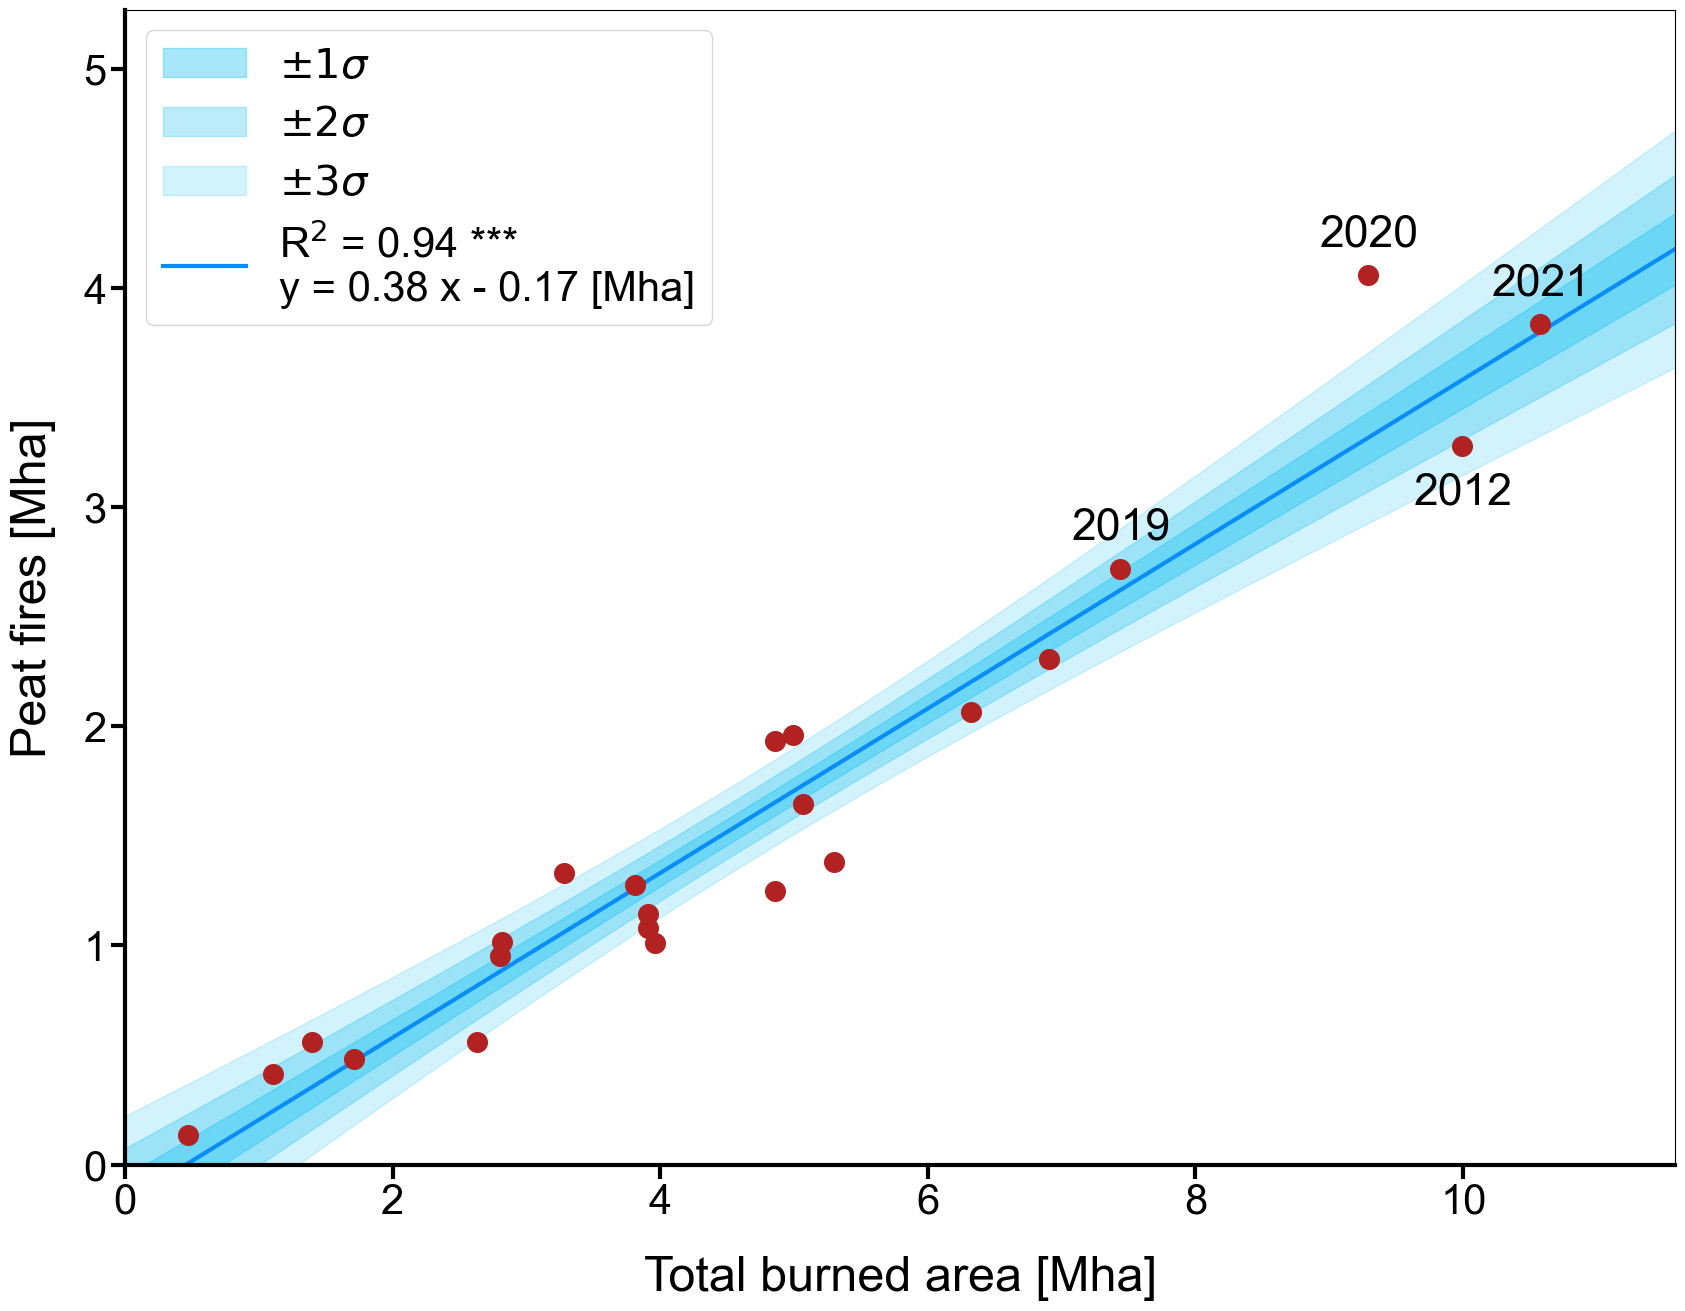

In [75]:
masked_df = agg_df.query("Zone == 'All'").copy()
# masked_df['PeatFire'] = masked_df.PeatFire * 1e-9
drivers = {
          "BA": 'Total burned area [Mha]',
            }
confidence = [[r"$\pm 1\sigma$", 0.3173, 0.4],
             [r"$\pm 2\sigma$", 0.0455, 0.3],
             [r"$\pm 3\sigma$",0.0027, 0.2]]
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
for i, d in enumerate(list(drivers.keys())[:]):
    try:
        ax = axes.flatten()[i]
    except:
        ax = axes
    x, y = masked_df[d], masked_df.PeatFire 
    # lm = sm.OLS(x, y, missing='drop').fit()
    # print(lm.summary())
    
    # coefficients = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
    # print(coefficients)
    # # y_fit = np.polyval(coefficients, x)
    # y_fit = np.exp(coefficients[1]) * np.exp(coefficients[0] * x)
    # r2 = metrics.r2_score(y, y_fit)
    # print(r2)
    ax.scatter(x, y, 
       marker='o', color='firebrick', edgecolor='firebrick', zorder=3, s=200)
    x_edge = (x.max() - x.min()) * 0.1
    ax.set_xlim(x.min()-x_edge, x.max()+x_edge)
    x_curve = np.linspace(x.min()-x_edge, x.max()+x_edge, 100)  # More points for a smooth curve
    # y_curve = np.exp(coefficients[1]) * np.exp(coefficients[0] * x_curve)

    # model = smf.glm(formula=f'PeatFire ~ {d}', data=masked_df, 
    #                 family=sm.families.Gaussian(link=sm.families.links.Log())).fit()
    # y_fit = model.predict(x)
    model = sm.GLM(y, sm.add_constant(x), 
           family=sm.families.Gaussian(link=sm.families.links.Log())).fit()
    if d == 'BA':
        model = sm.OLS(y, sm.add_constant(x)).fit()        
    y_fit = model.predict(sm.add_constant(x))
    # p_value = stats.chi2.sf(model.pearson_chi2, model.df_model)
    p_value = model.pvalues[1]
    slope = model.params.iloc[1]
    intercept = model.params.iloc[0]
    r2 = metrics.r2_score(y, y_fit)
    # print(r2)
    pos_int = intercept >= 0
    sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
    
    predictions = model.get_prediction(sm.add_constant(x_curve))
    y_curve = predictions.predicted
    for l, val, t in confidence:
        lower = predictions.conf_int(alpha=val)[:, 0] 
        upper = predictions.conf_int(alpha=val)[:, 1] 
        ax.fill_between(x_curve, lower, upper, alpha=t, color='#23c3f1', label=l)
    
    texts = []
    labelled = masked_df.loc[np.isin(masked_df.Year, [2012, 2019, 2020, 2021]), 'Year']
    offsets = {2012: -0.3, 2019: 0.1, 2020: 0.1, 2021: 0.1}
    for j, year in zip(labelled.index, labelled):
        # plt.annotate(year, (x[i], y[i]), textcoords="offset points", xytext=(0, 10), ha='center')
        texts.append(ax.text(x.loc[j], y.loc[j]+offsets[year], year, fontsize=32, ha='center'));
    
    adjust_text(texts, ax=ax, expand=(0, 0), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
                arrowprops=dict(arrowstyle='->', color='none'), # ensure the labeling is clear by adding arrows
                );
    y_edge = (upper.max() - lower.min()) * 0.1
    ax.set_ylim(min(lower.min(), y.min())-y_edge, max(y.max(), upper.max())+y_edge)
    if d == 'BA':
        ax.set_ylim(ax.get_xlim()[0], None)
        lab = 'R$^2$ = {:.2f} {} \ny = {:.2f} x{}{} {:.2f} [Mha]'.format(r2, sig, slope, " +" * pos_int, " -" * (not pos_int), abs(intercept))
    else:
        lab = 'R$^2$ = %.2f %s' %(r2, sig)                                                            
    ax.plot(x_curve, y_curve, color='#0a8df6', label=lab, lw=3)
    
    ax.set_xlabel(drivers[d], size=35, labelpad=25)
    ax.set_ylabel('Peat fires [Mha]', size=35, labelpad=20)
    ax.tick_params(labelsize = 30, size=10, width=3)
    # slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    # rmse = metrics.mean_squared_error(x, y, squared=False)
    # mae = metrics.mean_absolute_error(x, y)
    # x2 = np.linspace(*ax.get_xlim(), 100)
    # line = slope * x2 + intercept
    # pos_int = intercept >= 0
    # sig = '***' * (p_value <= 0.001) + '**' * (0.001 < p_value <= 0.01) + '*' * (0.01 < p_value <= 0.05) + '' * (p_value > 0.05)
    log_loc = "upper left" * (slope > 0) + "upper right" * (slope < 0)
    # ax.plot(x2, line, label='R$^2$ = %.2f %s' %(r_value**2, sig), color='blue', linestyle='--', dashes=(2, 2))
    legend = ax.legend(frameon=True, loc=log_loc, fontsize=30)
    legend._legend_box.sep = 10
    ax.spines[['bottom', 'left']].set_linewidth(3)
    # ax.text(-0.1, 1.05, f'{string.ascii_lowercase[i]})', transform=ax.transAxes, fontsize=14, fontweight='bold', ha='center')

    ax.set_xlim(0)
    ax.set_ylim(0)    

    plt.savefig(f'{local_path}/Plots/Peatfires_BA_regression.jpeg', 
               dpi= 500, bbox_inches='tight', pad_inches=1*1/2.54)

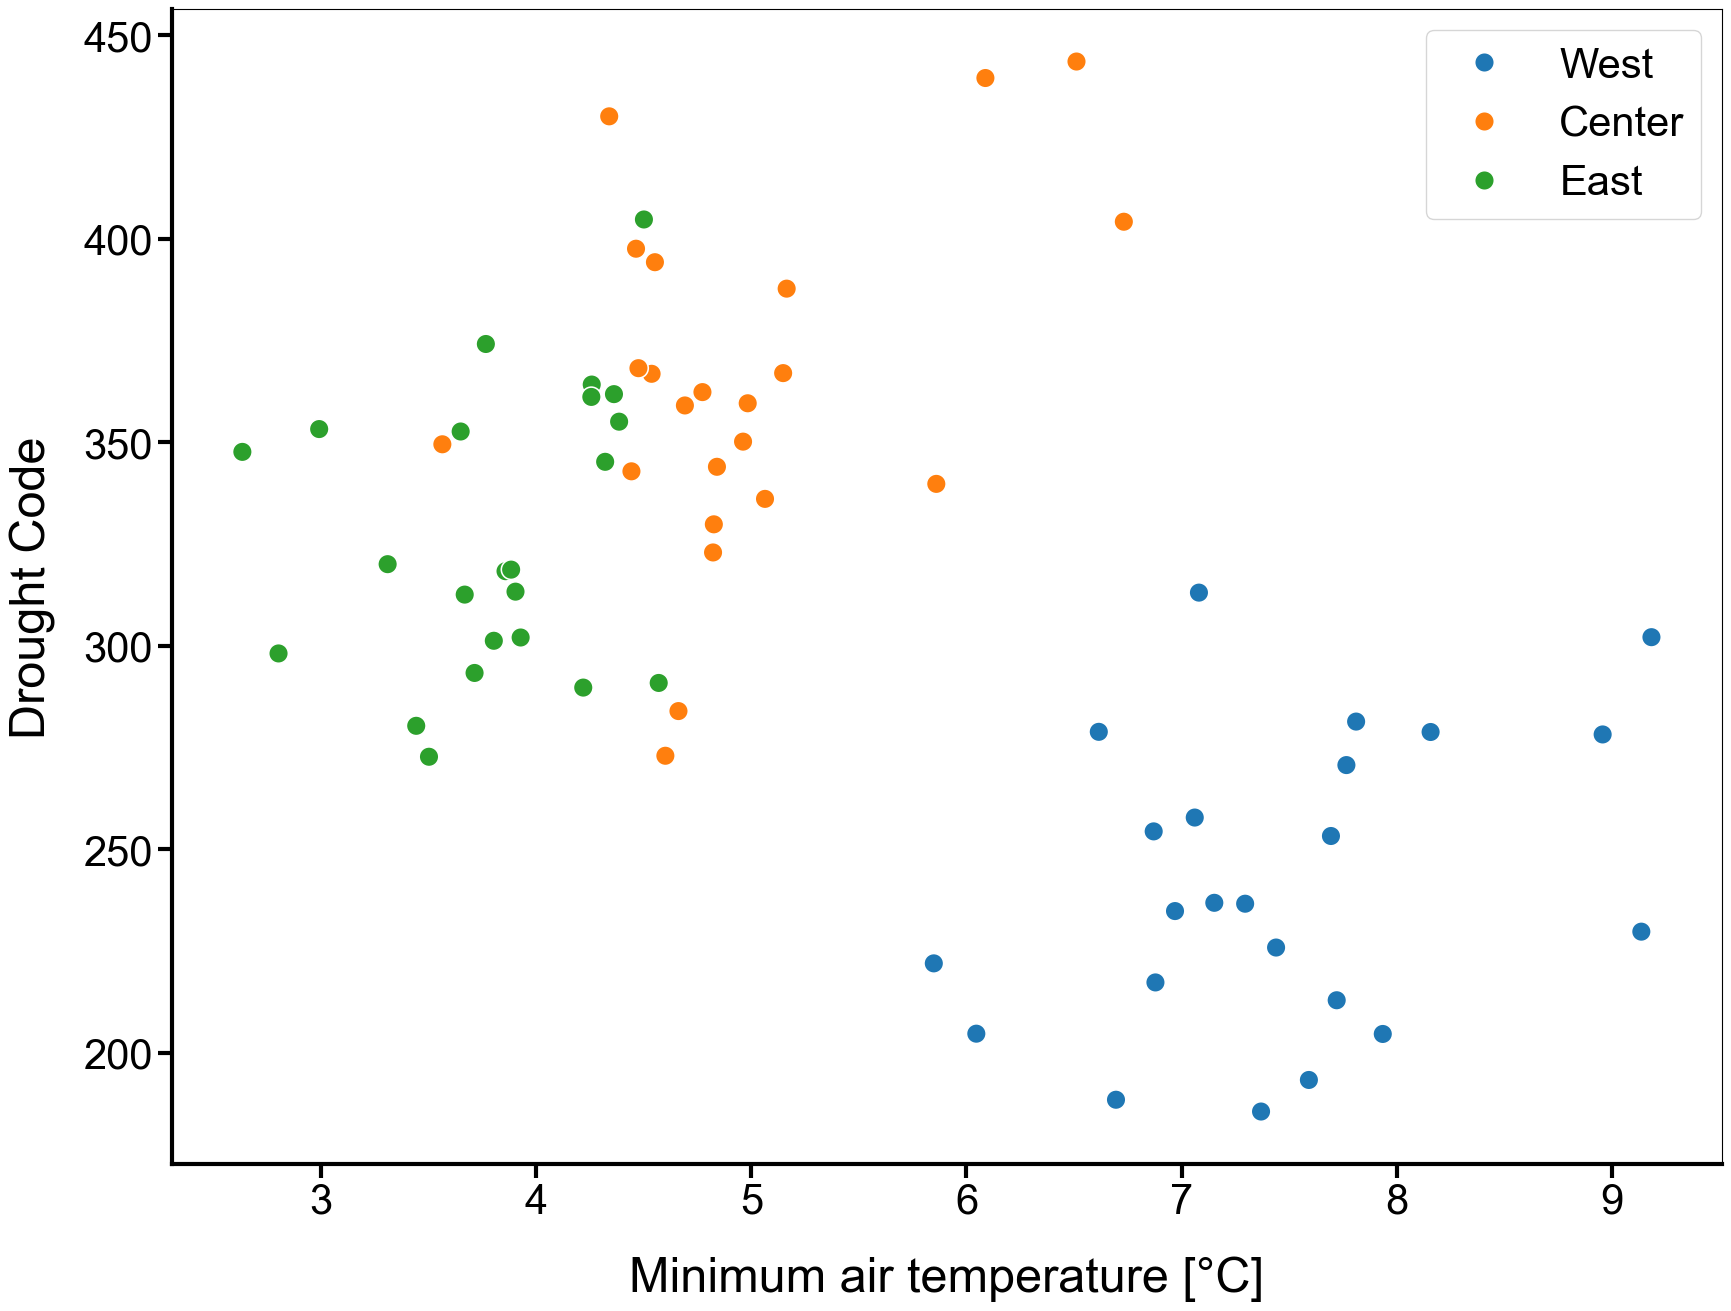

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
masked_df = agg_df.query("Zone in ['West', 'Center', 'East']")

x, y = masked_df.Tmin, masked_df.DC
sns.scatterplot(data=masked_df, y=y.name, x=x.name, 
       marker='o', hue='Zone', ax=ax, s=200
                # palette=reversed(colors)
               )

ax.set_xlabel('Minimum air temperature [°C]', size=35, labelpad=25)
ax.set_ylabel('Drought Code', size=35, labelpad=20)
legend = ax.legend(frameon=True, fontsize=30)
legend._legend_box.sep = 10
ax.tick_params(labelsize = 30, size=10, width=3)
ax.spines[['bottom', 'left']].set_linewidth(3)

plt.savefig(f'{local_path}/Plots/Tmin-DC.jpeg', 
           dpi= 500, bbox_inches='tight', pad_inches=1*1/2.54)

## 7) Fires and seasonality

In [ ]:
def get_JDs(local_path, tile, year):
    BA_file = f'{local_path}/ByTile/{tile}/Enhanced/Yearly/BAMT_BA_Siberia_Lndst_{year}_{tile}_JD_Correct_Patches.tif'
    with rio.open(BA_file) as src:
        BA = src.read(1)
    JD = BA[BA > 0]
    area = Global_Functions.get_pixel_area(BA_file)[BA > 0]
    return JD, area

def weighted_quantile(values, quantiles, weights=None, values_sorted=False):
    values = np.array(values)
    quantiles = np.array(quantiles)
    
    if weights is None:
        weights = np.ones(len(values))
    weights = np.array(weights)
    
    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        weights = weights[sorter]
    
    weighted_cumsum = np.cumsum(weights) - 0.5 * weights
    weighted_cumsum /= np.sum(weights)
    
    return np.interp(quantiles, weighted_cumsum, values)

In [15]:
Tiles = os.listdir(f'{local_path}/PeatFire/ByTile')
JD_stats = {}
for year in range(2001, 2024):
    JD_stats[str(year)] = {}
    ls = Parallel(n_jobs=16, verbose=100, backend='threading') (delayed (get_JDs) 
                (local_path, tile, year) for tile in Tiles[:])
    JD = np.concatenate([i[0] for i in ls])
    area = np.concatenate([i[1] for i in ls])
    JD_stats[str(year)]['quantiles'] =  weighted_quantile(JD, [0.01, 0.5, 0.99], weights=area)
    JD_stats[str(year)]['hist'] = np.histogram(JD, bins=np.arange(JD.min(), JD.max()+1, 1), weights=area)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    3.5s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    3.5s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    4.3s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    4.9s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    4.9s
[Parallel(n_jobs=16)]: Done  14 tasks      | elapsed:    5.3s
[Parallel(n_jobs=16)]: Done  15 tasks      | elaps

In [22]:
hist_stats = pd.DataFrame([], index=range(1, 367), dtype=np.float32())
for i, year in enumerate(range(2001, 2024)):
    idx = JD_stats[str(year)]['hist'][1]
    counts = np.cumsum(JD_stats[str(year)]['hist'][0]) / 1e10
    hist_stats.loc[idx[:-1], str(year)] = counts
    hist_stats.loc[idx[-1]:, str(year)] = counts[-1]
    hist_stats.loc[:idx[0]:, str(year)] = 0
    print(year, counts[-1])
    # agg_df.loc[(agg_df.Year == year) & (agg_df.Zone == 'All'), ['JD_p1', 'JD_p50', 'JD_p95']] = JD_stats[str(year)]['quantiles']
    # july_1st = int(datetime(year=year, month=9, day=1).strftime('%j'))
    # print(july_1st)
    # agg_df.loc[(agg_df.Year == year) & (agg_df.Zone == 'All'), ['AREA_bfJuly']] = counts[-1] - counts[np.where(idx==july_1st-1)]
    # agg_df.loc[(agg_df.Year == year) & (agg_df.Zone == 'All'), ['Prop_bfJuly']] = 100 - counts[np.where(idx==july_1st-1)] / counts[-1] * 100

2001 4.8652102662035785
2002 6.915770127300652
2003 6.329522466419176
2004 1.4090078278369245
2005 3.2834818597496302
2006 3.9705945085809584
2007 1.1176652579191426
2008 2.637331328792758
2009 3.9161830697494127
2010 3.819730086861694
2011 4.866441297817407
2012 10.00075629951449
2013 5.073294690067691
2014 3.912371129526854
2015 0.4768583265442115
2016 5.30661413718988
2017 2.809233953679369
2018 5.004378060996298
2019 7.4438661673211515
2020 9.296075454060453
2021 10.581078827595102
2022 1.7151020261810115
2023 2.8203220428456666


In [185]:
a = np.histogram(np.repeat(range(1, 101), 10), bins=range(1, 102), weights=np.repeat(range(1, 11), 100))
a

(array([ 10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  20,  20,  20,
         20,  20,  20,  20,  20,  20,  20,  30,  30,  30,  30,  30,  30,
         30,  30,  30,  30,  40,  40,  40,  40,  40,  40,  40,  40,  40,
         40,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  60,  60,
         60,  60,  60,  60,  60,  60,  60,  60,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  80,  80,  80,  80,  80,  80,  80,  80,
         80,  80,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100]),
 array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  

In [87]:
datetime.strptime('2021227', '%Y%j')

datetime.datetime(2021, 8, 15, 0, 0)

In [85]:
minday, maxday = 172, 232
hist_stats.loc[maxday, :] - hist_stats.loc[minday, :], 
print(((hist_stats.loc[maxday, :] - hist_stats.loc[minday, :]) / hist_stats.iloc[-1, :] * 100).mean())
(hist_stats.loc[maxday, :] - hist_stats.loc[minday, :]) / hist_stats.iloc[-1, :] * 100

77.0358342288461


2001    89.687159
2002    76.483918
2003    73.531073
2004    43.933101
2005    78.227995
2006    90.249865
2007    89.404690
2008    78.509027
2009    65.553958
2010    85.376399
2011    35.333573
2012    80.977384
2013    85.786928
2014    94.687898
2015    36.447037
2016    76.484588
2017    84.711800
2018    86.315010
2019    88.328543
2020    72.610685
2021    90.456905
2022    83.973739
2023    84.752910
dtype: float64

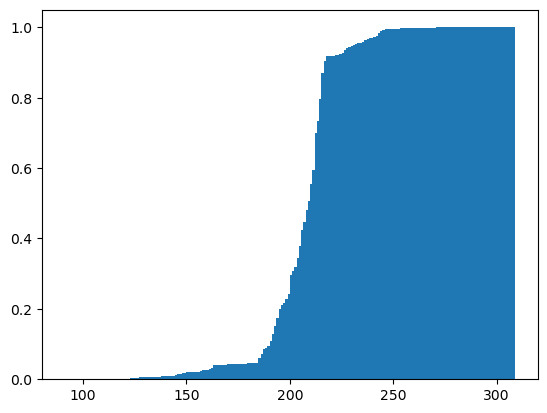

In [321]:
plt.hist(np.concatenate(JD), bins=200, cumulative=True, density=True);

In [65]:
np.sort(hist_stats.loc[150, :])[::-1]

array([2.0493968 , 0.56159023, 0.41481204, 0.36443837, 0.28243271,
       0.2687458 , 0.26261112, 0.23958745, 0.22941585, 0.2249926 ,
       0.22414917, 0.16989361, 0.15757405, 0.11274559, 0.1117056 ,
       0.09647534, 0.08752827, 0.08715358, 0.07878812, 0.07668347,
       0.07003532, 0.05811604, 0.04844555])

In [48]:
hist_stats.to_csv(f'{local_path}/PeatFire/BG_CC/data/BA_Seasons.csv')

In [16]:
hist_stats = pd.read_csv(f'{local_path}/PeatFire/BG_CC/data/BA_Seasons.csv', index_col='Unnamed: 0')
hist_stats

2001     2002      2003      2004      2005      2006      2007  \
1    0.00000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
2    0.00000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0.00000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
4    0.00000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
5    0.00000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
..       ...      ...       ...       ...       ...       ...       ...   
362  4.86521  6.91577  6.329522  1.409007  3.283482  3.970595  1.117665   
363  4.86521  6.91577  6.329522  1.409008  3.283482  3.970595  1.117665   
364  4.86521  6.91577  6.329522  1.409008  3.283482  3.970595  1.117665   
365  4.86521  6.91577  6.329522  1.409008  3.283482  3.970595  1.117665   
366  4.86521  6.91577  6.329522  1.409008  3.283482  3.970595  1.117665   

         2008      2009     2010  ...      2014      2015      2016      2017  \
1    0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
2    0.000000  0.000000  0.00000  ...  0.000012  0.000030  0.000020  0.000024   
3    0.000000  0.000000  0.00000  ...  0.000012  0.000038  0.000021  0.000025   
4    0.000000  0.000000  0.00000  ...  0.000045  0.000038  0.000062  0.000025   
5    0.000000  0.000000  0.00000  ...  0.000046  0.000040  0.000063  0.000026   
..        ...       ...      ...  ...       ...       ...       ...       ...   
362  2.637331  3.916183  3.81973  ...  3.912253  0.476820  5.306537  2.809180   
363  2.637331  3.916183  3.81973  ...  3.912265  0.476827  5.306539  2.809206   
364  2.637331  3.916183  3.81973  ...  3.912371  0.476858  5.306546  2.809234   
365  2.637331  3.916183  3.81973  ...  3.912371  0.476858  5.306614  2.809234   
366  2.637331  3.916183  3.81973  ...  3.912371  0.476858  5.306614  2.809234   

             2018      2019      2020       2021      2022      2023  
1    0.000000e+00  0.000000  0.000000   0.000000  0.000000  0.000000  
2    7.517353e-07  0.000026  0.000086   0.000039  0.000057  0.000006  
3    1.662280e-06  0.000027  0.000088   0.000071  0.000058  0.000006  
4    2.146679e-06  0.000028  0.000088   0.000079  0.000060  0.000015  
5    2.429230e-06  0.000034  0.000114   0.000079  0.000068  0.000078  
..            ...       ...       ...        ...       ...       ...  
362  5.004277e+00  7.443791  9.295874  10.580944  1.714872  2.820153  
363  5.004300e+00  7.443824  9.295963  10.580977  1.714915  2.820185  
364  5.004378e+00  7.443866  9.295979  10.581079  1.715102  2.820322  
365  5.004378e+00  7.443866  9.296075  10.581079  1.715102  2.820322  
366  5.004378e+00  7.443866  9.296075  10.581079  1.715102  2.820322  

[366 rows x 23 columns]

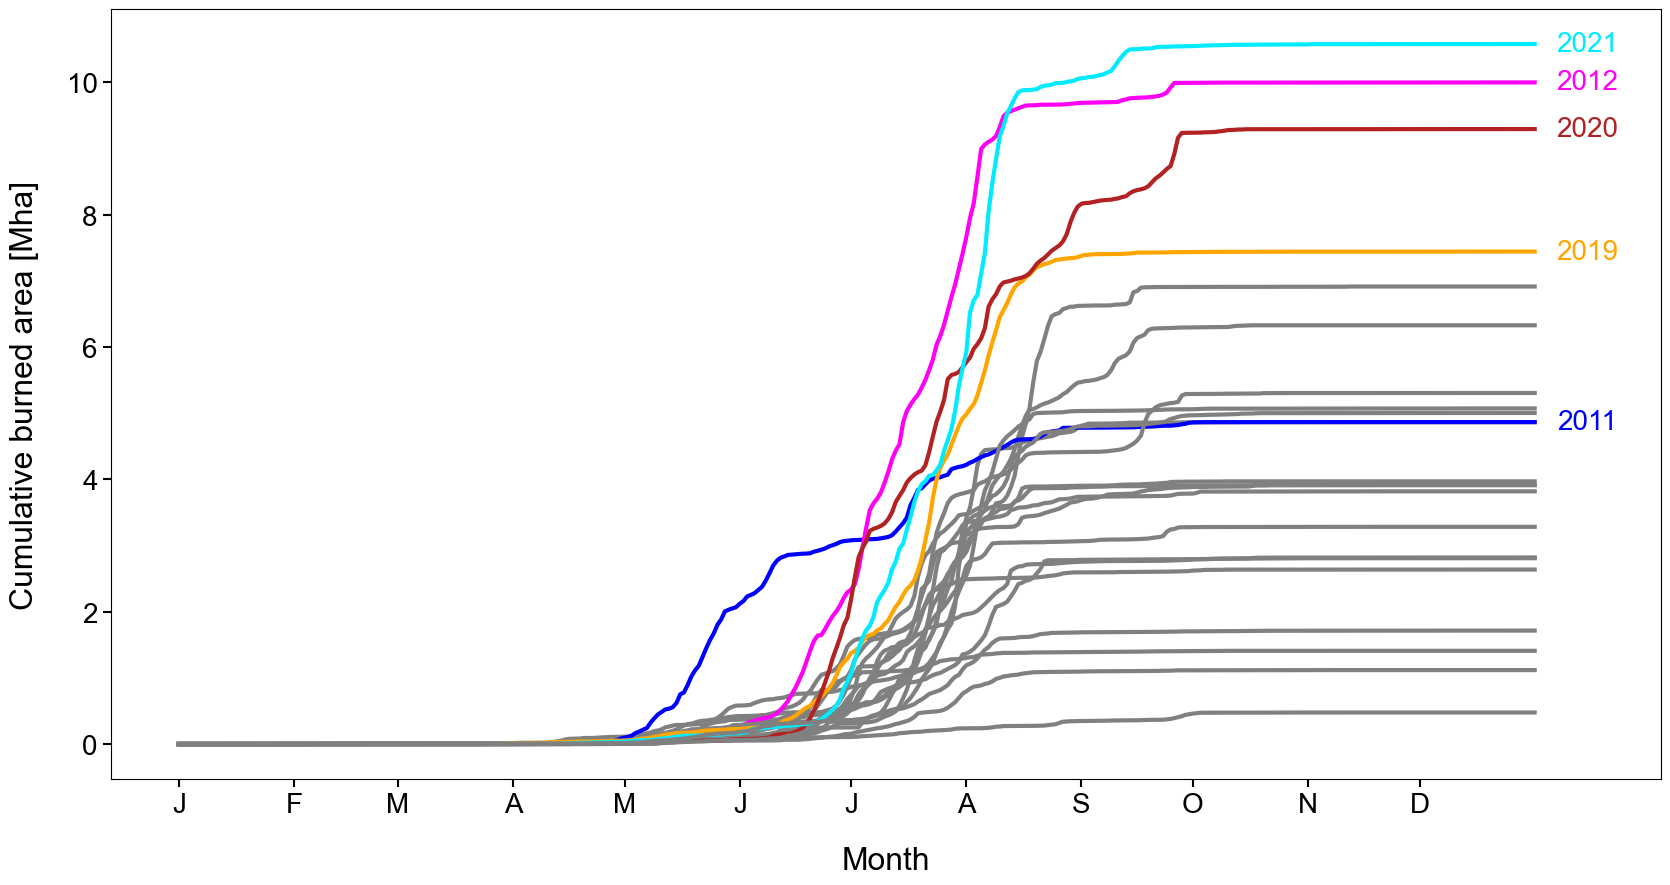

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# Example data: Julian days
# julian_data = np.random.randint(1, 365, size=1000)  # Simulated Julian days
start_date = datetime(year=2001, month=1, day=1)  # Reference year
end_date = datetime(year=2001, month=12, day=31)

# Compute histogram
# counts, bin_edges = np.histogram(np.concatenate(, bins=24)  # 24 bins = biweekly for a year
# counts, d = hist
# Convert bin edges (Julian days) to dates
# bin_edges = np.arange(1, 366, 15)
# dates = [start_date + timedelta(days=int(day) - 1) for day in bin_edges]  # Bin edges to dates
dates = pd.date_range(start_date, end_date, freq='MS')
# Format dates for biweekly labels
ticks = [int(date.strftime('%j')) for date in dates]
date_labels = [date.strftime('%b')[:1] for date in dates]  # E.g., 'Jan 01', 'Jan 15', etc.

# # Plot histogram using bin centers
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# bin_center_dates = [start_date + timedelta(days=int(day) - 1) for day in bin_centers]  # Center as dates
# center_labels = [date.strftime('%b %d') for date in bin_center_dates]

# plt.bar(bin_centers, np.cumsum(counts), width=(bin_edges[1] - bin_edges[0]), edgecolor='k', align='center')
# plt.plot(d[:-1], np.cumsum(counts))

cmap = plt.cm.Spectral_r
anomalous = {'2012': '#ff00f7', 
              '2019': 'orange', 
              '2020': 'firebrick', 
              '2021': '#00ebff',
              '2011': 'blue'
            }
palette = dict(zip(hist_stats.columns, [cmap(i) for i in range(cmap.N)][::int(cmap.N / len(hist_stats.columns))]))
palette = {**{i: 'grey' for i in hist_stats.columns if i not in anomalous.keys()},
             **anomalous 
}
hist_stats.plot.line(color=palette, ax=ax, lw=3, ms=15)
ax.set_xlabel('Month', size=23, labelpad=20);
ax.set_ylabel('Cumulative burned area [Mha]', size=23, labelpad=20);

# Adjust x-axis labels
# plt.xticks(ticks=bin_centers[::2], labels=center_labels[::2], rotation=45)  # Show every other label
ax.set_xticks(ticks=ticks, labels=date_labels, rotation=0);
ax.get_legend().remove()
ax.tick_params(labelsize = 20, size=6, width=1.5)
for y, c in anomalous.items():
    ax.text(380, hist_stats.loc[366, y], s=y, fontsize=20, ha='center', va='center', color=c)
ax.set_xlim(None, 400);

plt.savefig(f'{local_path}/Plots/BA_Siberia_Season.jpeg', 
               dpi= 500, bbox_inches='tight', pad_inches=1*1/2.54)

## 1) Label patch stats

In [19]:
labs_path = '/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/Samples_PF/labeling/peat'
local_path = '/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA'
zone, dataset = 'Siberia', 'Lndst'
cutoff = 16
logFile = open(f'{labs_path}/LogFile_Fire_Patch_overlap.txt', 'w')
grid = gpd.read_file(f'{local_path}/Regions/Tiles_Siberia_3dLon.shp')
all_data = []
for year in range(2017, 2023, 1):
# for f in glob.glob(os.path.join(labs_path, '**', '*[0-9][0-9][0-9][0-9].shp'), recursive=True)[:]:
    for f in glob.glob(f'{labs_path}/**/*{year}.shp', recursive=True)[:]:
        confidence = f.split('/')[-2]
        points = gpd.read_file(f)
        print(confidence, os.path.basename(f))
        points.drop(columns=['Id'], inplace=True)
        if 'nonpeat' in f:
            points['class'] = 0
        else:
            points['class'] = 1
        points = gpd.overlay(points, grid, how='intersection').drop(columns=['PROJ', 'Samples', 'NBR'])
        points['tile'] = ['TILE-' + i for i in points.TILE]
        points.drop(columns=['TILE'], inplace=True)
        points['longitude'], points['latitude'] = points.geometry.x, points.geometry.y
        points['zone'] = 'Siberia'
        points.loc[:, "JD"] = np.zeros(points.index.shape, np.int16)
        points.loc[:, "burn_year"] = np.zeros(points.index.shape, np.int16)        
        for tile in np.unique(points.tile)[:]:
            p = points.query(f"tile == '{tile}'").index
            coords = list(zip(points.loc[p, "longitude"], 
                         points.loc[p, "latitude"]))
            zone = points.loc[p, "zone"].values[0]
            with rio.open(f'{local_path}/{zone}/ByTile/{tile}/Enhanced/Yearly/BAMT_BA_Siberia_Lndst_{year}_{tile}_JD_Correct_Patches.tif') as src:
                jd0 = np.array([int(i[0]) for i in src.sample(coords)])
            with rio.open(f'{local_path}/{zone}/ByTile/{tile}/Enhanced/Yearly/BAMT_BA_Siberia_Lndst_{year-1}_{tile}_JD_Correct_Patches.tif') as src:
                jd1 = np.array([int(i[0]) for i in src.sample(coords)])
            mask0 = jd0 > 0
            mask1 = (jd0 <= 0) & (jd1 > 0)
            year_arr = np.full(jd0.shape, year, np.int16) * mask0 + np.full(jd0.shape, year-1, np.int16) * mask1
            jd = jd0 * mask0 + jd1 * mask1
            points.loc[p, "JD"] = jd
            points.loc[p, "burn_year"] = year_arr
            
            for y in np.unique(year_arr):
                if y == 0:
                    continue
                p = points.query(f"tile == '{tile}' and burn_year == {y}").index
                coords = list(zip(points.loc[p, "longitude"], 
                             points.loc[p, "latitude"]))
                try:
                    with rio.open(f'{local_path}/{zone}/ByTile/{tile}/Voronoi/FRP/Hotspots_FRP_{y}_{tile}.tif') as src:
                        points.loc[p, "FRP"] = [i[0] for i in src.sample(coords)]
                except:
                    if tile == 'TILE-72N147E':
                        with rio.open(f'{local_path}/{zone}/ByTile/TILE-72N144E/Voronoi/FRP/Hotspots_FRP_{y}_TILE-72N144E.tif') as src:
                            points.loc[p, "FRP"] = [i[0] for i in src.sample(coords)]
        
                with rio.open(f"{local_path}/{zone}/ByTile/{tile}/Patches/TIF/BAMT_BA_{zone}_{dataset}_Patches-{cutoff}_{y}_{tile}.tif") as src:
                    labels = [f"{tile}_{int(i[0]):05}" for i in src.sample(coords)]
                    
                with rio.open(f'{local_path}/{zone}/PeatFire/ByTile/{tile}/Pixel/BA_Peatland_{tile}_{y}.tif') as src:
                    peatfire = np.array([i[0] for i in src.sample(coords)])
                    val_old = np.array([-3, -2, 0, 2, 3])        
                    val_new = np.array([0, 25, 0, 75, 100])
                    reclassified = Global_Functions.replace_numpy_list(peatfire, val_old, val_new)                    
                    points.loc[p, "peatmap"] = reclassified
                csv = pd.read_csv(f"{local_path}/{zone}/ByTile/{tile}/Patches/Tabular/BAMT_BA_{zone}_{dataset}_Patch-Stats-{cutoff}_{y}_{tile}.csv")
                for idx, l in zip(p, labels):
                    points.loc[idx, csv.columns.str.lower()] = csv.loc[csv.ID == l, csv.columns].values[0]

        try:
            points = points[['class', 'peatmap', 'burn_year', 'JD', 'FRP', 'tile', *csv.columns.str.lower(), 'geometry']]
            points.to_file(os.path.splitext(f)[0] + '_patches.shp')
            all_data.append(points)
        except:
            continue

df = pd.concat(all_data, ignore_index=True)
df

confident nonpeat2017.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


confident peat2017.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


confident nonpeat2018.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


confident peat2018.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


confident nonpeat2019.shp
confident peat2019.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


confident nonpeat2020.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


confident peat2020.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


probably nonpeat2020.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


probably peat2020.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


confident nonpeat2021.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


confident peat2021.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


probably nonpeat2021.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


probably peat2021.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


confident nonpeat2022.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


confident peat2022.shp


Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


class  peatmap  burn_year   JD        FRP          tile  \
0         0    100.0       2017  209   6.890826  TILE-66N072E   
1         0    100.0       2017  209   6.890826  TILE-66N072E   
2         0    100.0       2017  211  54.415955  TILE-66N072E   
3         0    100.0       2017  211  23.282784  TILE-66N072E   
4         0    100.0       2017  203   7.309941  TILE-66N075E   
...     ...      ...        ...  ...        ...           ...   
5479      1     25.0       2022  167  33.865250  TILE-70N156E   
5480      1    100.0       2022  270  35.246292  TILE-70N156E   
5481      1    100.0       2022  270  35.246292  TILE-70N156E   
5482      1    100.0       2022  270  35.246292  TILE-70N156E   
5483      1      NaN          0    0        NaN  TILE-70N156E   

                      id                                   bounds  \
0     TILE-66N072E_00005    [72.46075, 65.2115, 72.47375, 65.217]   
1     TILE-66N072E_00005    [72.46075, 65.2115, 72.47375, 65.217]   
2     TILE-66N072E_00003    [73.39225, 65.40325, 73.436, 65.4425]   
3     TILE-66N072E_00003    [73.39225, 65.40325, 73.436, 65.4425]   
4     TILE-66N075E_00181    [75.2075, 64.33625, 75.317, 64.38325]   
...                  ...                                      ...   
5479  TILE-70N156E_00164   [156.47675, 68.405, 156.68375, 68.521]   
5480  TILE-70N156E_00163  [158.76225, 68.755, 158.7675, 68.75875]   
5481  TILE-70N156E_00159   [158.8225, 68.74675, 158.85375, 68.76]   
5482  TILE-70N156E_00135  [158.578, 68.80925, 158.6095, 68.82275]   
5483                 NaN                                      NaN   

              area  dupplicated  min_jd  max_jd  duration  med_jd     mean_jd  \
0     1.059850e+05          0.0   209.0   209.0       1.0   209.0  209.000000   
1     1.059850e+05          0.0   209.0   209.0       1.0   209.0  209.000000   
2     4.449905e+06          0.0   206.0   211.0       6.0   210.0  209.080486   
3     4.449905e+06          0.0   206.0   211.0       6.0   210.0  209.080486   
4     1.334310e+07          0.0   202.0   204.0       3.0   203.0  203.041644   
...            ...          ...     ...     ...       ...     ...         ...   
5479  3.437442e+07          0.0   164.0   173.0      10.0   167.0  166.679857   
5480  3.158574e+04          0.0   262.0   270.0       9.0   270.0  269.714286   
5481  6.036199e+05          0.0   262.0   271.0      10.0   270.0  269.900467   
5482  3.704263e+05          0.0   262.0   270.0       9.0   270.0  269.556568   
5483           NaN          NaN     NaN     NaN       NaN     NaN         NaN   

      peat_fraction  peat_confident                    geometry  
0         60.308471    1.304483e+04   POINT (72.46413 65.21296)  
1         60.308471    1.304483e+04   POINT (72.47327 65.21519)  
2         32.679090    1.599284e+05   POINT (73.40710 65.40944)  
3         32.679090    1.599284e+05   POINT (73.41423 65.40506)  
4         92.549432    1.202847e+07   POINT (75.26878 64.36695)  
...             ...             ...                         ...  
5479      88.847845    2.981058e+07  POINT (156.64990 68.45471)  
5480     100.000000    3.158574e+04  POINT (158.76453 68.75690)  
5481      95.234955    5.748571e+05  POINT (158.83612 68.75208)  
5482      81.281392    2.998223e+05  POINT (158.58850 68.81531)  
5483            NaN             NaN  POINT (158.45050 68.85730)  

[5484 rows x 18 columns]

In [62]:
local_path

'/media/amin/DISK6T/PhD/Landsat_BA/Siberia'

In [95]:
df.rename(columns={'id': 'patch_id'}, inplace=True)
df.reset_index(inplace=True)
df.rename(columns={'index': 'id'}, inplace=True)
df.to_file(f'{local_path}/Siberia/PeatFire/BG_CC/data/Peatfire_labels.shp', index=True)

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


In [63]:
local_path = '/media/amin/DISK6T/PhD/Landsat_BA/Siberia'
df = gpd.read_file(f'{local_path}/PeatFire/BG_CC/data/Peatfire_labels.shp', index_col='id')
df

index    id  class  peatmap  burn_year   JD        FRP          tile  \
0         0     0      0    100.0       2017  209   6.890826  TILE-66N072E   
1         1     1      0    100.0       2017  209   6.890826  TILE-66N072E   
2         2     2      0    100.0       2017  211  54.415955  TILE-66N072E   
3         3     3      0    100.0       2017  211  23.282784  TILE-66N072E   
4         4     4      0    100.0       2017  203   7.309941  TILE-66N075E   
...     ...   ...    ...      ...        ...  ...        ...           ...   
5479   5479  5479      1     25.0       2022  167  33.865250  TILE-70N156E   
5480   5480  5480      1    100.0       2022  270  35.246292  TILE-70N156E   
5481   5481  5481      1    100.0       2022  270  35.246292  TILE-70N156E   
5482   5482  5482      1    100.0       2022  270  35.246292  TILE-70N156E   
5483   5483  5483      1      NaN          0    0        NaN  TILE-70N156E   

                patch_id                                   bounds  ...  \
0     TILE-66N072E_00005    [72.46075, 65.2115, 72.47375, 65.217]  ...   
1     TILE-66N072E_00005    [72.46075, 65.2115, 72.47375, 65.217]  ...   
2     TILE-66N072E_00003    [73.39225, 65.40325, 73.436, 65.4425]  ...   
3     TILE-66N072E_00003    [73.39225, 65.40325, 73.436, 65.4425]  ...   
4     TILE-66N075E_00181    [75.2075, 64.33625, 75.317, 64.38325]  ...   
...                  ...                                      ...  ...   
5479  TILE-70N156E_00164   [156.47675, 68.405, 156.68375, 68.521]  ...   
5480  TILE-70N156E_00163  [158.76225, 68.755, 158.7675, 68.75875]  ...   
5481  TILE-70N156E_00159   [158.8225, 68.74675, 158.85375, 68.76]  ...   
5482  TILE-70N156E_00135  [158.578, 68.80925, 158.6095, 68.82275]  ...   
5483                 NaN                                      NaN  ...   

      dupplicate  min_jd  max_jd  duration  med_jd     mean_jd  \
0            0.0   209.0   209.0       1.0   209.0  209.000000   
1            0.0   209.0   209.0       1.0   209.0  209.000000   
2            0.0   206.0   211.0       6.0   210.0  209.080486   
3            0.0   206.0   211.0       6.0   210.0  209.080486   
4            0.0   202.0   204.0       3.0   203.0  203.041644   
...          ...     ...     ...       ...     ...         ...   
5479         0.0   164.0   173.0      10.0   167.0  166.679857   
5480         0.0   262.0   270.0       9.0   270.0  269.714286   
5481         0.0   262.0   271.0      10.0   270.0  269.900467   
5482         0.0   262.0   270.0       9.0   270.0  269.556568   
5483         NaN     NaN     NaN       NaN     NaN         NaN   

                                                all_jds peat_fract  \
0     [209 209 209 209 209 209 209 209 209 209 209 2...  60.308471   
1     [209 209 209 209 209 209 209 209 209 209 209 2...  60.308471   
2                         [209 209 209 ... 211 211 211]  32.570108   
3                         [209 209 209 ... 211 211 211]  32.570108   
4                         [204 204 204 ... 202 202 202]  91.546792   
...                                                 ...        ...   
5479                      [167 167 167 ... 168 168 168]  87.758147   
5480  [270 270 270 270 270 270 270 270 270 270 270 2...  98.214373   
5481                      [270 270 270 ... 270 270 270]  94.861207   
5482                      [270 270 270 ... 270 270 270]  79.838751   
5483                                                NaN        NaN   

        peat_confi                    geometry  
0     1.304483e+04   POINT (72.46413 65.21296)  
1     1.304483e+04   POINT (72.47327 65.21519)  
2     1.599284e+05   POINT (73.40710 65.40944)  
3     1.599284e+05   POINT (73.41423 65.40506)  
4     1.189553e+07   POINT (75.26878 64.36695)  
...            ...                         ...  
5479  2.946887e+07  POINT (156.64990 68.45471)  
5480  3.102173e+04  POINT (158.76453 68.75690)  
5481  5.726011e+05  POINT (158.83612 68.75208)  
5482  2.944784e+05  POINT (158.58850 68.81531)  
5483   

In [64]:
np.unique(df.loc[df['class'] == 1].peatmap, return_counts=True)[1][[2, 3]].sum()/np.unique(df.loc[df['class'] == 1].peatmap, return_counts=True)[1][:4].sum()*100

99.13430042115114

In [68]:
np.count_nonzero(np.isfinite((df.loc[df['class'] == 1].peatmap)))

4274

In [71]:
np.unique(df.loc[df['class'] == 1].peatmap, return_counts=True)[1][[2, 3]].sum()

4237

In [69]:
np.array([ 30,    7, 3506,  731])[2:].sum()/np.array([ 30,    7, 3506,  731]).sum()

0.9913430042115114

In [82]:
np.unique(df.loc[df['class'] == 1].peatmap, return_counts=True)

(array([  0.,  25.,  75., 100.,  nan]), array([  30,    7, 3506,  731,  116]))

Text(0, 0.5, 'Fraction from visual labelling (%)')

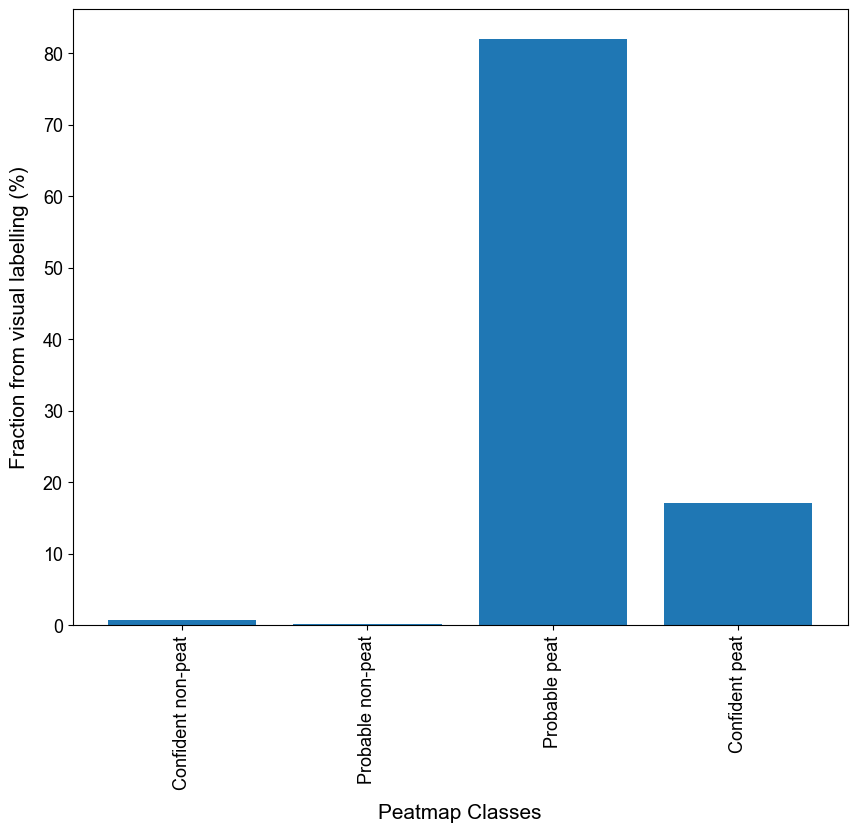

In [65]:
fig = plt.figure(figsize=(10,8))
labs = ['Confident non-peat', 'Probable non-peat', 'Probable peat', 'Confident peat']
plt.bar(labs, 
        np.unique(df.loc[df['class'] == 1].peatmap, return_counts=True)[1][:4]/np.unique(df.loc[df['class'] == 1].peatmap, return_counts=True)[1][:4].sum()*100, 
         width=0.8)
plt.xlabel('Peatmap Classes', size=15, labelpad=10)
plt.xticks(rotation=90)
plt.tick_params(labelsize=13)
plt.ylabel('Fraction from visual labelling (%)', size=15, labelpad=10)
# plt.savefig('/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA/Siberia/Samples_PF/labeling/Peat-labelling_Comparison.jpeg',
#            dpi= 500, bbox_inches='tight', pad_inches=1*1/2.54)